In [1]:
import functions_metrics as metrics
import functions_select_cluster as select_cluster
import functions_read_query as read_query
import functions_reading as reading
import pickle
import time
import matplotlib.pyplot as plt
import matplotlib_venn
import seaborn as sns
import spacy
import en_core_web_sm
import copy
import collections
import json
import scipy.stats
import functools
import numpy as np

nlp = en_core_web_sm.load()
beta_name_d = {'by_beta_0.125': 0.125, 'by_beta_0.25': 0.25, 
               'by_beta_0.5': 0.5, 'by_beta_1.0': 1.0, 'by_beta_2.0': 2.0,
               'by_beta_4.0': 4.0, 'by_beta_8.0': 8.0,
               'by_beta_16.0': 16.0, 'by_beta_32.0': 32.0,
               'by_beta_64.0': 64.0, 'by_beta_128.0': 128.0,}
beta_name_l = list(beta_name_d)

In [2]:
# Pickle load variables

ref_row_clean = pickle.load(open('ref_row_clean.pickle', 'rb'))
year_pmid_netid_d_ref = pickle.load(open('year_pmid_netid_d_ref.pickle', 'rb'))
year_netid_pmid_d_ref =  pickle.load(open('year_netid_pmid_d_ref.pickle', 'rb'))

netid_2015_d = pickle.load(open('netid_2015_d.pickle', 'rb'))
netid_2016_d = pickle.load(open('netid_2016_d.pickle', 'rb'))

metrics_d = pickle.load(open('metrics_d.pickle', 'rb'))

t_d = pickle.load(open('t_d.pickle', 'rb'))

f = open('clean_ref.pickle', 'rb')
clean_ref = pickle.load(f)
f.close()

titles_59_beta1_b_retrieved = pickle.load(open('titles_59_beta1_b_retrieved.pickle', 'rb'))
titles_59_beta1_s_retrieved = pickle.load(open('titles_59_beta1_s_retrieved.pickle', 'rb'))
titles_59_beta4_s_retrieved = pickle.load(open('titles_59_beta4_s_retrieved.pickle', 'rb'))

titles_47_beta2_b_retrieved = pickle.load(open('titles_47_beta2_b_retrieved.pickle', 'rb'))
titles_47_beta2_s_retrieved = pickle.load(open('titles_47_beta2_s_retrieved.pickle', 'rb'))
titles_47_beta16_s_retrieved = pickle.load(open('titles_47_beta16_s_retrieved.pickle', 'rb'))

titles_80_beta2_b_retrieved = pickle.load(open('titles_80_beta2_b_retrieved.pickle', 'rb'))
titles_80_beta2_s_retrieved = pickle.load(open('titles_80_beta2_s_retrieved.pickle', 'rb'))
titles_80_beta8_s_retrieved = pickle.load(open('titles_80_beta8_s_retrieved.pickle', 'rb'))

In [49]:
# Ploting functions

def venn_Tuple(ya_yb_yc, ya_yb_nc, ya_nb_yc, ya_nb_nc, na_yb_yc, na_yb_nc, na_nb_yc):
    """Create the tuple to be used in matplotlib_venn.venn3
    The arguments are the size (INT) of the sets in the diagram.
    In the diagram there are 3 circles: a, b and c.
    The sets are the combination of these circles.
    The name of the arguments indicates the combination. For each circle a, b or c, you have the sufix y for yes and n for no.
    Then, for example, ya_yb_nc means the elements that are in circle a and circle b but not circle c.
    """
    venn_tuple = {'111': ya_yb_yc, '110': ya_yb_nc, '101': ya_nb_yc, '100': ya_nb_nc, '011': na_yb_yc, '010': na_yb_nc, '011': na_nb_yc}
    return venn_tuple

def plot_Venn3(topic_retrieve_data, set_labels=('A', 'B', 'C'), figsize=(20, 20)):
    venn_tuple = venn_Tuple(ya_yb_yc=len(topic_retrieve_data.positives_intersection)
                           ,ya_yb_nc=len(topic_retrieve_data.negatives_intersection)
                           ,ya_nb_yc=len(topic_retrieve_data.b_positives_not_in_s)
                           ,ya_nb_nc=len(topic_retrieve_data.b_negatives_not_in_s)
                           ,na_yb_yc=len(topic_retrieve_data.s_positives_not_in_b)
                           ,na_yb_nc=len(topic_retrieve_data.s_negatives_not_in_b)
                           ,na_nb_yc=0)

    fig, ax = plt.subplots(figsize=figsize)
    matplotlib_venn.venn3(subsets=venn_tuple, ax=ax, set_colors=('dodgerblue', 'chartreuse', 'red'), alpha=1, set_labels=set_labels)
    plt.show()
    
def plot_Boolean_Vs_Scimacro_Presicion(X, Y, set_title='', 
                set_xlabel='Boolean query precision', set_ylabel='Greedy algorithm precision',
                figsize=(5, 10), set_yticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
                ylim=(0, 1.01), xlim=(0, 0.61)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.set_style('whitegrid')
    ax = sns.scatterplot(ax=ax, x=X, y=Y)
    ax.set_yticks(set_yticks)
    ax.set(ylim=ylim, xlim=xlim)
    ax.set_title(set_title)
    ax.set_xlabel(set_xlabel)
    ax.set_ylabel(set_ylabel)
    return plt.show()


def plot_Series_Of_Boxplots(data, set_title='', set_ylabel='', set_xlabel='β values', figsize=(33, 10), ylim=False, set_yscale=False, font_scale=1, set_yticks=False,
                  x_label_l=['0.125', '0.25', '0.5', '1', '2',
                             '4', '8', '16', '32', '64', '128']):
    sns.set(font_scale=font_scale)
    sns.set_style('whitegrid')
    
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.boxplot(ax=ax, data=data, showfliers=False, linewidth=0.5)
    ax = sns.swarmplot(ax=ax, data=data, color='.25', size=5)
    ax.set_xticklabels(x_label_l, rotation=45)
    if set_yticks:
        ax.set_yticks(set_yticks)
    if ylim:
        ax.set(ylim=ylim)
    if set_yscale:
        ax.set_yscale(set_yscale)
    ax.set_title(set_title)
    ax.set_ylabel(set_ylabel)
    ax.set_xlabel(set_xlabel)
    return plt.show()

In [4]:
# NLP functions
    
def get_Noun_Index_L(doc_class):
    index_l = []
    for index in range(len(doc_class)):
        pos = doc_class[index].pos_
        if pos == 'NOUN' or pos == 'PROPN':
            index_l.append(index)
    return index_l

def expand_Noun_Phrase(np_index, doc_class):
    noun_phrase_indices = [np_index]
    for index in list(reversed(range(np_index))):
        pos = doc_class[index].pos_
        if pos == 'NOUN' or pos == 'ADJ' or pos == 'PROPN':
            noun_phrase_indices.append(index)
        else:
            break
    noun_phrase_indices = list(reversed(noun_phrase_indices))
    return noun_phrase_indices

def np_List_List(titles_list):
    np_words_l_l = []
    for title in titles_list:
        lower_title = title.lower()
        doc_class = nlp(lower_title)
        noun_index_l = get_Noun_Index_L(doc_class)
        done_np_indices = set()
        np_words_l = []
        for index in reversed(noun_index_l):
            if index not in done_np_indices:
                expanded_np_indices = expand_Noun_Phrase(index, doc_class)
                done_np_indices = done_np_indices.union(set(expanded_np_indices))
                np_words = tuple([doc_class[x].lemma_ for x in expanded_np_indices])
                np_words_l.append(np_words)
        np_words_l_l.append(np_words_l)
    return np_words_l_l

def get_Titles(netid_pubid_dict, netid_list):
    pubid_list = [netid_pubid_dict[netid] for netid in netid_list]
    title_list = []
    for pubid in pubid_list:
        try:
            title = read_query.retrieve_Pubmed_Title(pubid)
            title_list.append(title)
        except:
            print(pubid)
    return title_list

def get_Nounphrases(titles_list):
    np_words_l_l = np_List_List(titles_list)
    flat_list = [item for sublist in np_words_l_l for item in sublist]
    count_d = dict(collections.Counter(flat_list))
    sorted_count = sorted(list(count_d.items()), key=lambda x: x[1], reverse=True)
    np_dict = {'titles': np_words_l_l, 'count': sorted_count}
    return np_dict


In [5]:
# Data recording functions

def _Ref_Row_Clean(ref_row): # Indices based on the ref_head
    ref_row_clean = []
    for row in ref_row:
        topic_year = int(row[4])
        topic = int(row[3])
        pmid = int(row[2])
        net_id = int(row[5])
        ref_row_clean.append([topic_year, topic, net_id, pmid])
    return ref_row_clean

def change_Betas(cs, beta_l):
    cs['beta_l'] = beta_l
    cs['level_data'] = metrics.c_Metric_Recursion(cs['level_data'], cs['t_references_d'], cs['beta_l'])
    cs['t_greedy_data'] = select_cluster.c_T_Greedy_D(cs['level_data'], cs['t_references_d'], cs['beta_l'])
    cs['t_universal_fscore'] = select_cluster.c_T_Universal_Fscore_D(cs['t_references_d'], cs['beta_l'], cs['level_data'])
    return cs

class Topic_Retrieve_Data:
    def __init__(self, positives, b_retrieved, s_retrieved):
        '''
        s = SciMacro
        b = Boolean
        '''
        self.positives = positives
        self.b_retrieved = b_retrieved
        self.s_retrieved = s_retrieved
        
        self.b_positives = self.b_retrieved.intersection(self.positives)
        self.b_negatives = self.b_retrieved.difference(self.positives)

        self.s_positives = self.s_retrieved.intersection(self.positives)
        self.s_negatives = self.s_retrieved.difference(self.positives)
        
        self.positives_intersection = self.b_positives.intersection(self.s_positives)
        self.negatives_intersection = self.b_negatives.intersection(self.s_negatives)
        
        self.b_positives_not_in_s = self.b_positives.difference(self.s_retrieved)
        self.b_negatives_not_in_s = self.b_negatives.difference(self.s_retrieved)

        self.s_positives_not_in_b = self.s_positives.difference(self.b_retrieved)
        self.s_negatives_not_in_b = self.s_negatives.difference(self.b_retrieved)
        
def cluster_Stats(information_class):
    b_retrieved = len(information_class.b_retrieved)
    b_positives = len(information_class.b_positives)
    b_precision = float(b_positives) / b_retrieved
    s_retrieved = len(information_class.s_retrieved)
    s_positives = len(information_class.s_positives)
    s_precision = float(s_positives) / s_retrieved
    s_recall = float(s_positives) / b_positives
    intersection = len(information_class.positives_intersection) + len(information_class.negatives_intersection)
    jaccard = float(intersection) / (b_retrieved + s_retrieved - intersection)
    
    print('b_retrieved')
    print(b_retrieved)
    print('b_positives')
    print(b_positives)
    print('b_precision')
    print('{0:.2f}'.format(b_precision))

    print('s_retrieved')
    print(s_retrieved)
    print('s_positives')
    print(s_positives)
    print('s_precision')
    print('{0:.2f}'.format(s_precision))
    print('s_recall')
    print('{0:.2f}'.format(s_recall))

    print('intersection')
    print(intersection)
    print('jaccard')
    print('{0:.2f}'.format(jaccard)) 
    


In [6]:
# The number of reported papers from the original text of the systematic reviews

systematic_reviews_json = json.load(open('sigir_pico/systematic_reviews.json', 'r'))
url_d = {x['id']: x['url'] for x in systematic_reviews_json}
topic_sr_data_d = {x: {'url': url_d[x]} for x in t_d['by_beta_4.0']['topic']}

# These values are the values of trieved papers reported by the authors. I obtained from the systematic reviews, the web adress is in url_d.


#topic_sr_data_d[19]['retrieved'] = 179
#topic_sr_data_d[95]['retrieved'] = 117
#topic_sr_data_d[160]['retrieved'] = 147
# This SR were eliminated because I realized that their number of retrieved papers by boolean query is much greater than the number of retrieved papers reported. Then I noticed that the authors
# of the systematic review performed the boolean query in a database diferent from medline, therefore they should have never been part of this reseach.

#  Topic candidates:
#  Worse: 59, 155, 13
#  Best: 19, 95, 160, 47

# 19: http://onlinelibrary.wiley.com/doi/10.1002/14651858.CD011721.pub2/full
# This systematic review uses a search strategy that does not includes ovid, and it should be removed
#
# 95: http://onlinelibrary.wiley.com/doi/10.1002/14651858.CD010139.pub2/full
# The difference between the number of retrieved documents in the paper and the number of retrieved documents in the the boolean queries is
# too big (117 in the paper, 14373 in the boolean query). I will skip this systematic review for now.
#
# 160: http://onlinelibrary.wiley.com/doi/10.1002/14651858.CD003559.pub4/full
# Again, the difference is too big (147 in the paper, 70496 in the boolean query)


topic_sr_data_d[47]['retrieved'] = None
topic_sr_data_d[169]['retrieved'] = 3900
topic_sr_data_d[173]['retrieved'] = 396
topic_sr_data_d[155]['retrieved'] = 742 
topic_sr_data_d[151]['retrieved'] = 770
topic_sr_data_d[119]['retrieved'] = 131
topic_sr_data_d[124]['retrieved'] = 9579
topic_sr_data_d[11]['retrieved'] = 1796
topic_sr_data_d[13]['retrieved'] = 2050
topic_sr_data_d[6]['retrieved'] = 487
topic_sr_data_d[46]['retrieved'] = 3641
topic_sr_data_d[12]['retrieved'] = 2294
topic_sr_data_d[1]['retrieved'] = 24310
topic_sr_data_d[3]['retrieved'] = 2696
topic_sr_data_d[105]['retrieved'] = 1395 
topic_sr_data_d[93]['retrieved'] = 91
topic_sr_data_d[69]['retrieved'] = 10713 
topic_sr_data_d[80]['retrieved'] = 4072
topic_sr_data_d[51]['retrieved'] = 9676
topic_sr_data_d[89]['retrieved'] = 8524
topic_sr_data_d[78]['retrieved'] = 764
topic_sr_data_d[59]['retrieved'] = 591
topic_sr_data_d[79]['retrieved'] = 923
topic_sr_data_d[55]['retrieved'] = 662
topic_sr_data_d[136]['retrieved'] = 247

In [7]:
#skip # load data

f = open('cs_2014.pickle', 'rb')
cs_2014 = pickle.load(f)
f.close()
f = open('cs_2015.pickle', 'rb')
cs_2015 = pickle.load(f)
f.close()
f = open('cs_2016.pickle', 'rb')
cs_2016 = pickle.load(f)
f.close()

#f = open('clean_ref.pickle', 'rb')
#clean_ref = pickle.load(f)
#f.close()
#ref = reading.p_Tab_Delimited('PAPER2_topic_year_netid_CLEAN.txt')
#ref_head = ref[0]
#ref_row = ref[1:]
#print(ref_head)

#ref_row_clean = _Ref_Row_Clean(ref_row)

#year_pmid_netid_d_ref = {2014: {}, 2015: {}, 2016: {}}
#year_netid_pmid_d_ref = {2014: {}, 2015: {}, 2016: {}}

#for row in ref_row_clean:
#    year_pmid_netid_d_ref[row[0]][row[3]] = row[2]
#    year_netid_pmid_d_ref[row[0]][row[2]] = row[3]
    
#netid_2016 = reading.p_Tab_Delimited('PAPER2_netid_pmid_2016_UNION.txt')
#netid_head = netid_2016[0]
#netid_row = netid_2016[1:]
#print(netid_head)
#netid_2016_d = {int(x[0]): int(x[1]) for x in netid_row}

#netid_2015 = reading.p_Tab_Delimited('PAPER2_netid_pmid_2015_UNION.txt')
#netid_head = netid_2015[0]
#netid_row = netid_2015[1:]
#print(netid_head)
#netid_2015_d = {int(x[0]): int(x[1]) for x in netid_row}

beta_l = [0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0]

cs_2014 = change_Betas(cs_2014, beta_l)
cs_2015 = change_Betas(cs_2015, beta_l)
cs_2016 = change_Betas(cs_2016, beta_l)


NameError: name 'beta_l' is not defined

In [44]:
#skip # parse data

metrics_d = {}
for cs in (cs_2014, 
           cs_2015,
           cs_2016
          ):
    year = cs['YEAR']
    metrics_d[year] = {}
    topic_l = list(cs['t_references_d'])
    for topic in topic_l:
        metrics_d[year][topic] = {}
        condition_postitive_ids = set(clean_ref[year][topic]['positives_retrieved_in_net'])
        boolean_retrieved_ids = set(clean_ref[year][topic]['retrieved_in_net'])
        boolean_true_positive_ids = condition_postitive_ids
        boolean_recall = float(len(boolean_true_positive_ids)) / len(condition_postitive_ids)
        boolean_precision = float(len(boolean_true_positive_ids)) / len(boolean_retrieved_ids)
        betas = {}
        for beta_name in beta_name_l:
            betas[beta_name] = {}
            cs_temp = cs['level_data']
            stoping_level = cs['t_greedy_data'][topic][beta_name]['stoping_level']['level']
            for level in range(1, 14):
                cluster_id = cs['t_greedy_data'][topic][beta_name]['all_levels'][level]['cluster']
                if level == stoping_level:
                    scimacro_retrieved_ids = cs_temp['merging_data']['jclu_d'][cluster_id]
                    scimacro_true_positive_ids = cs_temp['t_positive_clusters_d'][topic][cluster_id]
                    break
                else:
                    cs_temp = cs_temp['children_clusters'][cluster_id]
            scimacro_recall = float(len(scimacro_true_positive_ids)) / len(condition_postitive_ids)
            scimacro_precision = float(len(scimacro_true_positive_ids)) / len(scimacro_retrieved_ids)
            beta_value = beta_name_d[beta_name]
            boolean_fscore = metrics.f_Score_From_Rec_Pre(boolean_recall, boolean_precision, beta_value)
            scimacro_fscore = metrics.f_Score_From_Rec_Pre(scimacro_recall, scimacro_precision, beta_value)
            max_net_fscore = max(cs['t_universal_fscore'][topic][beta_value])
            betas[beta_name]['stoping_level'] = stoping_level
            betas[beta_name]['scimacro_retrieved_ids'] = scimacro_retrieved_ids
            betas[beta_name]['scimacro_true_positive_ids'] = scimacro_true_positive_ids
            betas[beta_name]['scimacro_recall'] = scimacro_recall
            betas[beta_name]['scimacro_precision'] = scimacro_precision
            betas[beta_name]['beta_value'] = beta_value
            betas[beta_name]['boolean_fscore'] = boolean_fscore
            betas[beta_name]['scimacro_fscore'] = scimacro_fscore
            betas[beta_name]['max_net_fscore'] = max_net_fscore
        metrics_d[year][topic]['condition_postitive_ids'] = condition_postitive_ids
        metrics_d[year][topic]['boolean_retrieved_ids'] = boolean_retrieved_ids
        metrics_d[year][topic]['boolean_true_positive_ids'] = boolean_true_positive_ids
        metrics_d[year][topic]['boolean_recall'] = boolean_recall
        metrics_d[year][topic]['boolean_precision'] = boolean_precision
        metrics_d[year][topic]['betas'] = betas
        
        
# Remove 19, 95 and 160
# The reason is explained bellow
del(metrics_d[2014][160])
del(metrics_d[2015][95])
del(metrics_d[2016][19])

t_d = {}
for beta_name in beta_name_l:
    t_d[beta_name] = {}
    t_d[beta_name]['year'] = []
    t_d[beta_name]['topic'] = []
    t_d[beta_name]['condition_postitive'] = []
    t_d[beta_name]['boolean_precision'] = []
    t_d[beta_name]['boolean_recall'] = []
    t_d[beta_name]['boolean_fscore'] = []
    t_d[beta_name]['scimacro_precision'] = []
    t_d[beta_name]['scimacro_recall'] = []
    t_d[beta_name]['scimacro_fscore'] = []
    t_d[beta_name]['max_net_fscore'] = []
    t_d[beta_name]['precision_dif'] = []
    t_d[beta_name]['recall_dif'] = []
    t_d[beta_name]['fscore_dif'] = []
    t_d[beta_name]['max_net_fscore_dif'] = []
    t_d[beta_name]['scimacro_retrieved'] = []
    t_d[beta_name]['scimacro_retrieved_relevant'] = []
    t_d[beta_name]['boolean_retrieved'] = []
    t_d[beta_name]['scimacro_retrieved_over_boolean'] = []
    t_d[beta_name]['boolean_retrieved_over_scimacro'] = []
    t_d[beta_name]['retrieved_intersection'] = []
    t_d[beta_name]['retrieved_union'] = []
    t_d[beta_name]['retrieved_jackard'] = []
    t_d[beta_name]['scimacro_retrieved_exclusion'] = []
    t_d[beta_name]['boolean_retrieved_exclusion'] = []
    t_d[beta_name]['retrieved_intersection_over_scimacro'] = []
    t_d[beta_name]['retrieved_intersection_over_boolean'] = []
    t_d[beta_name]['retrieved_union_over_scimacro'] = []
    t_d[beta_name]['retrieved_union_over_boolean'] = []
    t_d[beta_name]['scimacro_retrieved_exclusion_over_scimacro'] = []
    t_d[beta_name]['scimacro_retrieved_exclusion_over_boolean'] = []
    t_d[beta_name]['boolean_retrieved_exclusion_over_scimacro'] = []
    t_d[beta_name]['boolean_retrieved_exclusion_over_boolean'] = []
    t_d[beta_name]['stoping_level'] = []
    for year in metrics_d:
        for topic in metrics_d[year]:
            
            
            condition_postitive = len(metrics_d[year][topic]['condition_postitive_ids'])
            
            boolean_precision = metrics_d[year][topic]['boolean_precision']
            boolean_recall = metrics_d[year][topic]['boolean_recall']
            boolean_fscore = metrics_d[year][topic]['betas'][beta_name]['boolean_fscore']
            
            stoping_level = metrics_d[year][topic]['betas'][beta_name]['stoping_level']
            
            scimacro_precision = metrics_d[year][topic]['betas'][beta_name]['scimacro_precision']
            scimacro_recall = metrics_d[year][topic]['betas'][beta_name]['scimacro_recall']
            scimacro_fscore = metrics_d[year][topic]['betas'][beta_name]['scimacro_fscore']
            max_net_fscore = metrics_d[year][topic]['betas'][beta_name]['max_net_fscore']
            
            precision_dif = scimacro_precision - boolean_precision
            recall_dif = scimacro_recall - boolean_recall
            fscore_dif = scimacro_fscore - boolean_fscore
            max_net_fscore_dif = scimacro_fscore - max_net_fscore
            
            scimacro_retrieved_ids = metrics_d[year][topic]['betas'][beta_name]['scimacro_retrieved_ids']
            scimacro_retrieved = len(scimacro_retrieved_ids)
            scimacro_retrieved_relevant = scimacro_recall*condition_postitive
            boolean_retrieved_ids = metrics_d[year][topic]['boolean_retrieved_ids']
            boolean_retrieved = len(boolean_retrieved_ids)
            scimacro_retrieved_over_boolean = float(scimacro_retrieved) / boolean_retrieved
            boolean_retrieved_over_scimacro = float(boolean_retrieved) / scimacro_retrieved
            
            retrieved_intersection_ids = scimacro_retrieved_ids.intersection(boolean_retrieved_ids)
            retrieved_intersection = len(retrieved_intersection_ids)
            retrieved_intersection_over_scimacro = float(retrieved_intersection) / scimacro_retrieved
            retrieved_intersection_over_boolean = float(retrieved_intersection) / boolean_retrieved
            
            scimacro_retrieved_exclusion = scimacro_retrieved - retrieved_intersection
            scimacro_retrieved_exclusion_over_scimacro = float(scimacro_retrieved_exclusion) / scimacro_retrieved
            scimacro_retrieved_exclusion_over_boolean = float(scimacro_retrieved_exclusion) / boolean_retrieved
            
            boolean_retrieved_exclusion = boolean_retrieved - retrieved_intersection
            boolean_retrieved_exclusion_over_scimacro = float(boolean_retrieved_exclusion) / scimacro_retrieved
            boolean_retrieved_exclusion_over_boolean = float(boolean_retrieved_exclusion) / boolean_retrieved
            
            retrieved_union_ids =  scimacro_retrieved_ids.union(boolean_retrieved_ids)
            retrieved_union = len(retrieved_union_ids)
            retrieved_union_over_scimacro = float(retrieved_union) / scimacro_retrieved
            retrieved_union_over_boolean = float(retrieved_union) / boolean_retrieved
            
            retrieved_jackard = float(retrieved_intersection) / retrieved_union
            
            t_d[beta_name]['year'].append(year)
            t_d[beta_name]['topic'].append(topic)
            t_d[beta_name]['condition_postitive'].append(condition_postitive)
            t_d[beta_name]['boolean_precision'].append(boolean_precision)
            t_d[beta_name]['boolean_recall'].append(boolean_recall)
            t_d[beta_name]['boolean_fscore'].append(boolean_fscore)
            t_d[beta_name]['scimacro_precision'].append(scimacro_precision)
            t_d[beta_name]['scimacro_recall'].append(scimacro_recall)
            t_d[beta_name]['scimacro_fscore'].append(scimacro_fscore)
            t_d[beta_name]['max_net_fscore'].append(max_net_fscore)
            t_d[beta_name]['precision_dif'].append(precision_dif)
            t_d[beta_name]['recall_dif'].append(recall_dif)
            t_d[beta_name]['fscore_dif'].append(fscore_dif)
            t_d[beta_name]['max_net_fscore_dif'].append(max_net_fscore_dif)
            t_d[beta_name]['scimacro_retrieved'].append(scimacro_retrieved)
            t_d[beta_name]['scimacro_retrieved_relevant'].append(scimacro_retrieved_relevant)
            t_d[beta_name]['boolean_retrieved'].append(boolean_retrieved)
            t_d[beta_name]['scimacro_retrieved_over_boolean'].append(scimacro_retrieved_over_boolean)
            t_d[beta_name]['boolean_retrieved_over_scimacro'].append(boolean_retrieved_over_scimacro)
            t_d[beta_name]['retrieved_intersection'].append(retrieved_intersection)
            t_d[beta_name]['retrieved_intersection_over_scimacro'].append(retrieved_intersection_over_scimacro)
            t_d[beta_name]['retrieved_intersection_over_boolean'].append(retrieved_intersection_over_boolean)
            t_d[beta_name]['scimacro_retrieved_exclusion'].append(scimacro_retrieved_exclusion)
            t_d[beta_name]['scimacro_retrieved_exclusion_over_scimacro'].append(scimacro_retrieved_exclusion_over_scimacro)
            t_d[beta_name]['scimacro_retrieved_exclusion_over_boolean'].append(scimacro_retrieved_exclusion_over_boolean)
            t_d[beta_name]['boolean_retrieved_exclusion'].append(boolean_retrieved_exclusion)
            t_d[beta_name]['boolean_retrieved_exclusion_over_scimacro'].append(boolean_retrieved_exclusion_over_scimacro)
            t_d[beta_name]['boolean_retrieved_exclusion_over_boolean'].append(boolean_retrieved_exclusion_over_boolean)
            t_d[beta_name]['retrieved_union'].append(retrieved_union)
            t_d[beta_name]['retrieved_union_over_scimacro'].append(retrieved_union_over_scimacro)
            t_d[beta_name]['retrieved_union_over_boolean'].append(retrieved_union_over_boolean)
            t_d[beta_name]['retrieved_jackard'].append(retrieved_jackard)
            t_d[beta_name]['stoping_level'].append(stoping_level)

In [7]:
# Analyse data

# Is condition_positive independent from the other atributes? I suspect the number of condition positive papers may be related with the performance:
# eg: a paper with lest condition positive papers may have less bolean presicion
# Should I use all the betas? I believe I should calculate this for each beta.

spearanr_metric_everybeta_l = [
'scimacro_precision', 'scimacro_recall', 'scimacro_fscore',
'max_net_fscore',
'precision_dif', 'recall_dif', 'fscore_dif', 'max_net_fscore_dif',
'scimacro_retrieved', 'retrieved_intersection', 'scimacro_retrieved_exclusion', 'boolean_retrieved_exclusion', 'retrieved_union',
'retrieved_intersection_over_scimacro', 'retrieved_intersection_over_boolean', 'retrieved_jackard',
'scimacro_retrieved_over_boolean', 'scimacro_retrieved_exclusion_over_boolean', 'retrieved_union_over_boolean'
]

correlation_d = {}
for metric in spearanr_metric_everybeta_l:
    data_metric = [item for beta_name in beta_name_l for item in t_d[beta_name][metric]]
    data_condition_postitive = [item for beta_name in beta_name_l for item in t_d[beta_name]['condition_postitive']]
    correlation = scipy.stats.spearmanr(data_condition_postitive, data_metric)[0]
    correlation_d[metric] = correlation

for item in correlation_d.items():
    print(item)
    
ttes_ind_metric_l = [
'boolean_precision','boolean_fscore', 'scimacro_precision', 'scimacro_recall', 'scimacro_fscore', 'max_net_fscore',
'precision_dif', 'recall_dif', 'fscore_dif', 'max_net_fscore_dif',
'retrieved_intersection_over_scimacro', 'retrieved_intersection_over_boolean', 'retrieved_jackard'
]

data_year_wise_d = {}
data_year_wise_d[2014] = []
data_year_wise_d[2015] = []
data_year_wise_d[2016] = []

for metric in ttes_ind_metric_l:
    data_metric = [item for beta_name in beta_name_l for item in t_d[beta_name][metric]]
    data_year = [item for beta_name in beta_name_l for item in t_d[beta_name]['year']]
    data_zip = list(zip(data_metric, data_year))
    data_year_wise_d[2014] += [item[0] for item in data_zip if item[1] == 2014]
    data_year_wise_d[2015] += [item[0] for item in data_zip if item[1] == 2015]
    data_year_wise_d[2016] += [item[0] for item in data_zip if item[1] == 2016]

ttest_d = {}  
for year_pair in [(2014, 2015), (2014, 2016), (2015, 2016)]:
    ttest_d[year_pair] = scipy.stats.ttest_ind(data_year_wise_d[year_pair[0]], data_year_wise_d[year_pair[1]])
    
for item in ttest_d.items():
    print(item)
    

('scimacro_precision', -0.16441255181831696)
('scimacro_recall', -0.036644224425132293)
('scimacro_fscore', -0.040288870414170556)
('max_net_fscore', 0.014843603020962723)
('precision_dif', -0.21121125924704282)
('recall_dif', -0.036644224425132293)
('fscore_dif', -0.08419258199290959)
('max_net_fscore_dif', -0.08787364524800748)
('scimacro_retrieved', 0.20557141884920627)
('retrieved_intersection', 0.2738985089455219)
('scimacro_retrieved_exclusion', 0.18228707546716025)
('boolean_retrieved_exclusion', 0.27330872340281415)
('retrieved_union', 0.30746194611193023)
('retrieved_intersection_over_scimacro', -0.11765934866668912)
('retrieved_intersection_over_boolean', 0.14474328442033463)
('retrieved_jackard', 0.16217740297914277)
('scimacro_retrieved_over_boolean', 0.10325211909518286)
('scimacro_retrieved_exclusion_over_boolean', 0.13452255857472564)
('retrieved_union_over_boolean', 0.13452255857472564)
((2014, 2015), Ttest_indResult(statistic=1.0920285016867486, pvalue=0.27492887422510

In [8]:
def plot_Boxplot_Horizontal(data, set_title='', set_xlabel='', figsize=(15, 3), xlim=False, ticks=True, font_scale=1):
    sns.set(font_scale=font_scale)
    sns.set_style('whitegrid')

    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.boxplot(ax=ax, data=data, showfliers=False, linewidth=0.5, orient='h')
    ax = sns.swarmplot(ax=ax, data=data, color='.25', orient='h')
    # Optionals
    if ticks:
        ax.set_yticklabels([metric], rotation=30)
    else:
        ax.set_yticklabels([''])
    if xlim:
        ax.set(xlim=xlim)
    ax.set_title(set_title)
    ax.set_xlabel(set_xlabel)
    return plt.show()

def plot_Boxplot_Horizontal_Break(data, suptitle='', set_xlabel='', figsize=(15, 3), ticks=True, font_scale=1, set_xlim_ax1=(0, 1), set_xlim_ax2=(0, 1)):
    ratio = 10
    sns.set(font_scale=font_scale)
    sns.set_style('whitegrid')

    fig, (ax1, ax2) = plt.subplots(figsize=figsize, ncols=2, nrows=1, sharey=True, gridspec_kw={'width_ratios': [ratio, 1]})
    ax1 = sns.boxplot(ax=ax1, data=data, showfliers=False, linewidth=0.5, orient='h')
    ax1 = sns.swarmplot(ax=ax1, data=data, color='.25', orient='h')
    ax2 = sns.swarmplot(ax=ax2, data=data, color='.25', orient='h')
    ax1.set_xlim(set_xlim_ax1[0], set_xlim_ax1[1])
    ax2.set_xlim(set_xlim_ax2[0], set_xlim_ax2[1])
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.grid(b=False)
    ax2.set_xticks(set_xlim_ax2)
    
    line_lenght = .05
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((1 - line_lenght/ratio, 1 + line_lenght/ratio), (-line_lenght, +line_lenght), **kwargs)
    ax1.plot((1 - line_lenght/ratio, 1 + line_lenght/ratio), (1 - line_lenght, 1 + line_lenght), **kwargs)
    kwargs.update(transform=ax2.transAxes)
    ax2.plot((-line_lenght, +line_lenght), (1 - line_lenght, 1 + line_lenght), **kwargs)
    ax2.plot((-line_lenght, +line_lenght), (-line_lenght, +line_lenght), **kwargs)
    ax1.tick_params(axis='x', rotation=45)
    ax2.tick_params(axis='x', rotation=45)

    if ticks:
        ax1.set_yticklabels([metric], rotation=30)
    else:
        ax1.set_yticklabels([''])
    fig.suptitle(suptitle) 
    ax1.set_xlabel(set_xlabel)
    return plt.show()

def plot_Precision_vs_Recall(X, Y, set_title='', 
                set_xlabel='', set_ylabel='',
                figsize=(10, 10),
                ylim=(-0.01, 1.01), xlim=(-0.01, 1.01), set_xticks=False, s=1, font_scale=4):
    sns.set(font_scale=font_scale)
    sns.set_style('whitegrid')

    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.scatterplot(ax=ax, x=X, y=Y, s=s)
    ax.set(ylim=ylim, xlim=xlim)
    ax.set_title(set_title)
    ax.set_xlabel(set_xlabel)
    ax.set_ylabel(set_ylabel)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if set_xticks:
        ax.set_xticks(set_xticks)
        ax.tick_params(axis='x', rotation=45)

    x = np.linspace(0.00001, 1, 100)
    y = np.linspace(0.00001, 1, 100)

    X, Y = np.meshgrid(x, y)
    def infunc_Fscore_R_P(recall, precision, b):
        b2 = b**2
        num = (1+b2) * precision * recall
        den = (b2*precision) + recall
        fscore = num / den
        return fscore
    Z = infunc_Fscore_R_P(Y, X, 8)

    contours = plt.contour(X, Y, Z, 4, colors='red', linewidths=1, linestyles='dotted')
    plt.clabel(contours, inline=True, fontsize=30)

    return plt.show()

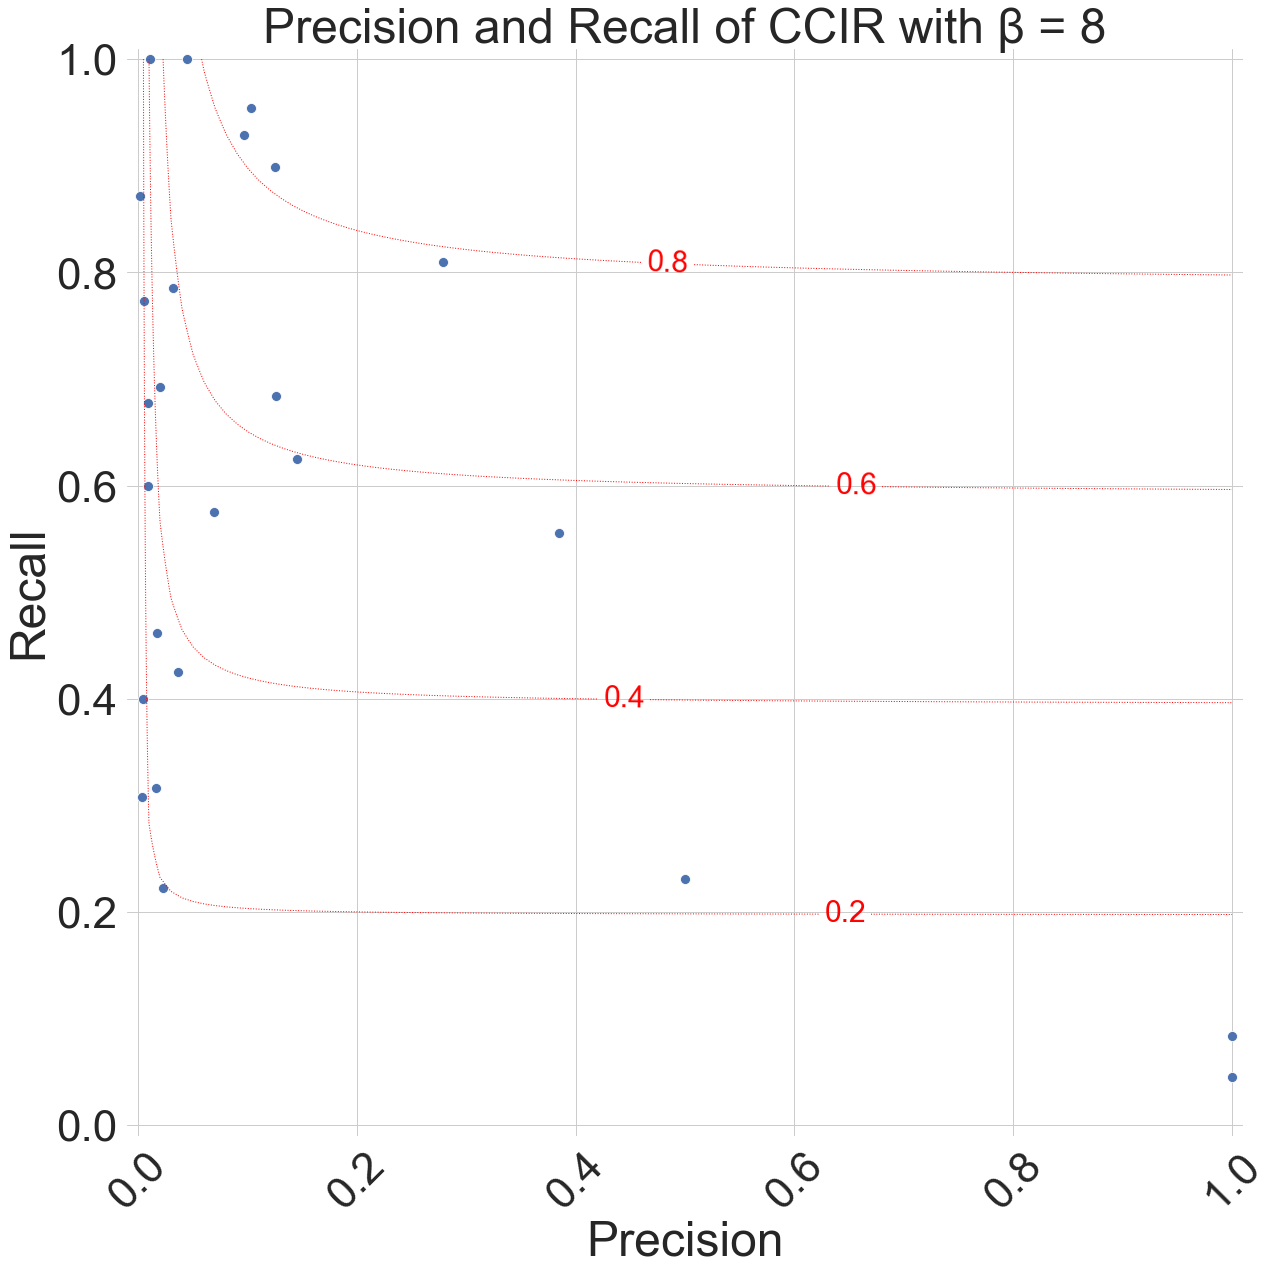

In [48]:
beta_name = 'by_beta_8.0'


plot_Precision_vs_Recall(t_d[beta_name]['scimacro_precision'], t_d[beta_name]['scimacro_recall'], set_title='Precision and Recall of CCIR with β = 8', 
                set_xlabel='Precision', set_ylabel='Recall', figsize=(20,20), set_xticks=[0, 0.2, 0.4, 0.6, 0.8, 1], s=100)

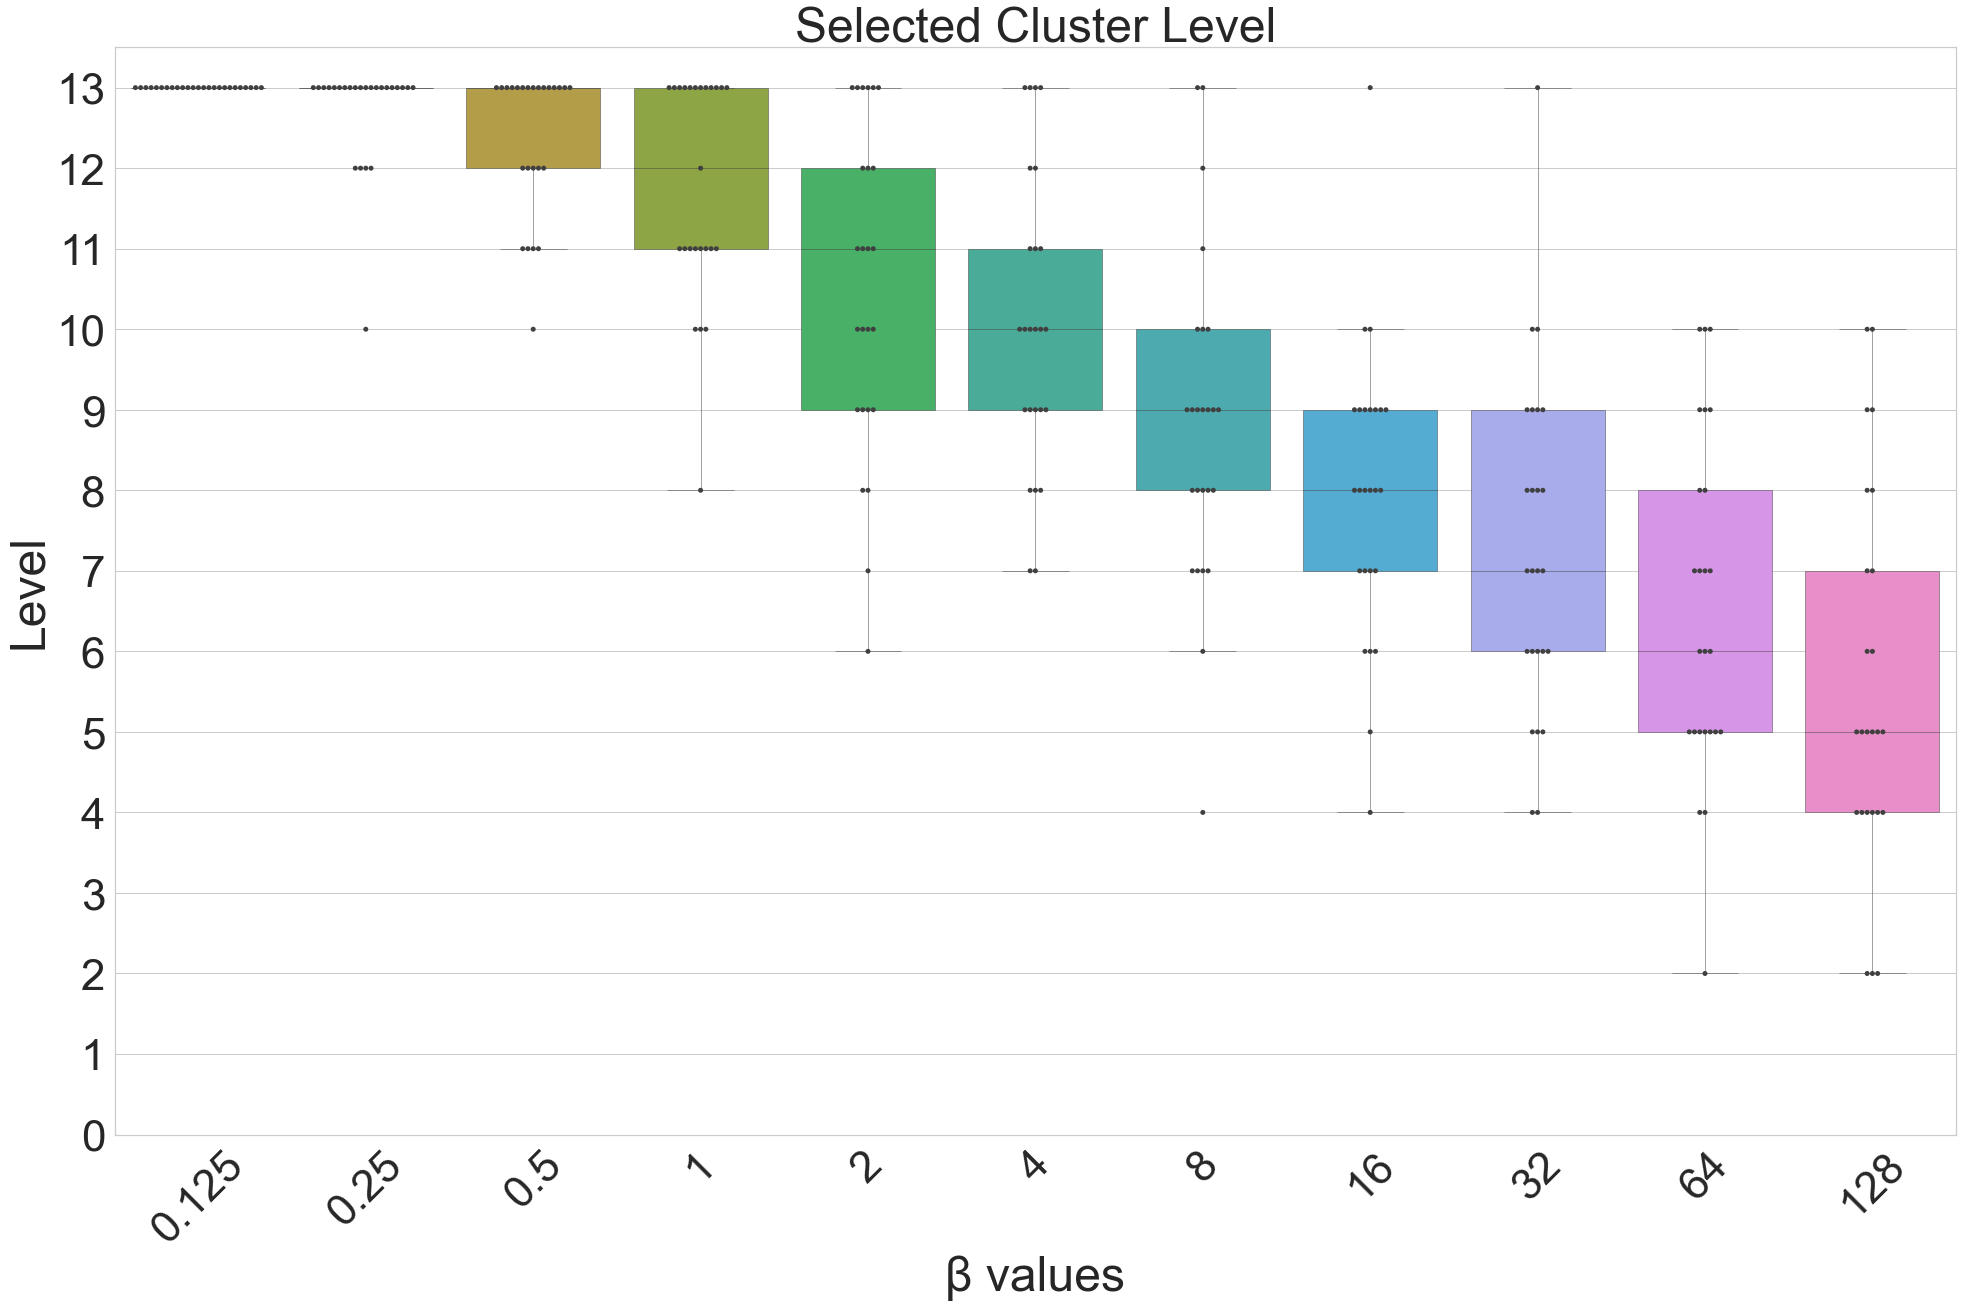

In [50]:
metric = 'stoping_level'
plot_Series_Of_Boxplots([t_d[beta_name][metric] for beta_name in beta_name_l], set_yticks=range(0,14), ylim=(0,13.5),
                        set_title='Selected Cluster Level', set_ylabel='Level',
                        font_scale=4, figsize=(33, 20))

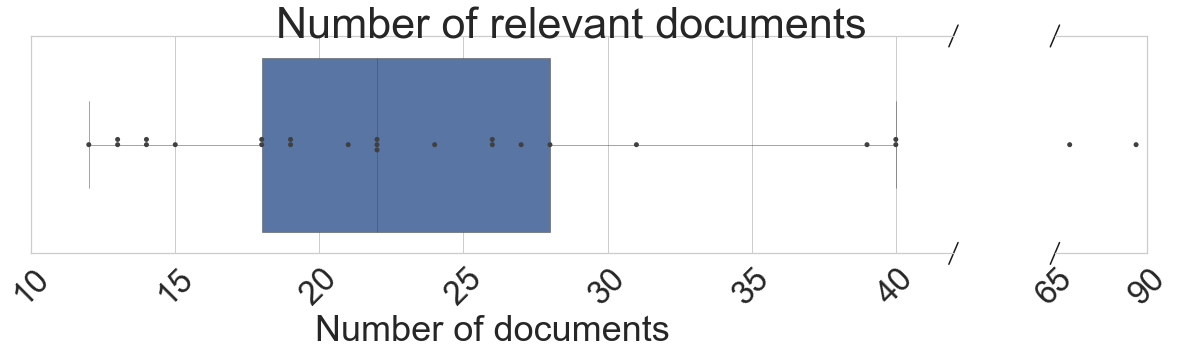

In [11]:
metric = 'condition_postitive'
beta_name = 'by_beta_0.125'
data = t_d[beta_name][metric]
plot_Boxplot_Horizontal_Break(data, suptitle='Number of relevant documents', set_xlabel='Number of documents', 
                              ticks=False, font_scale=3, set_xlim_ax1=(10, 42), set_xlim_ax2=(65, 90), figsize=(20, 4))

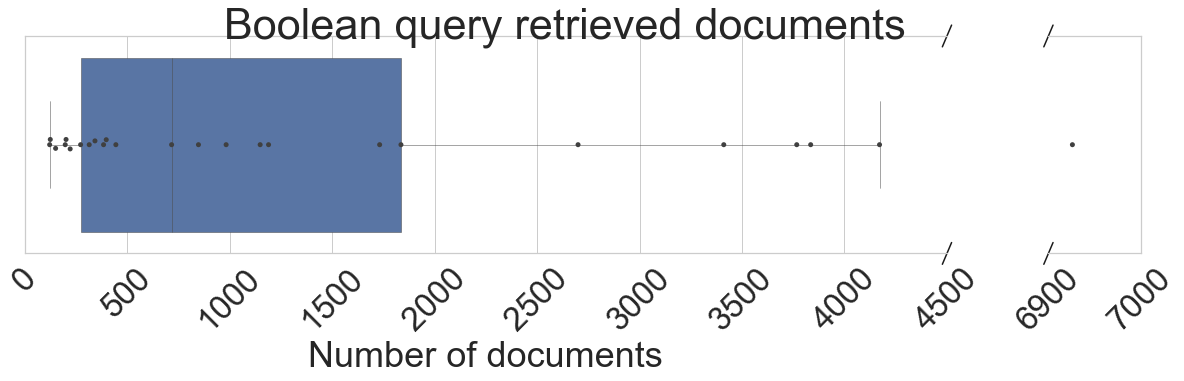

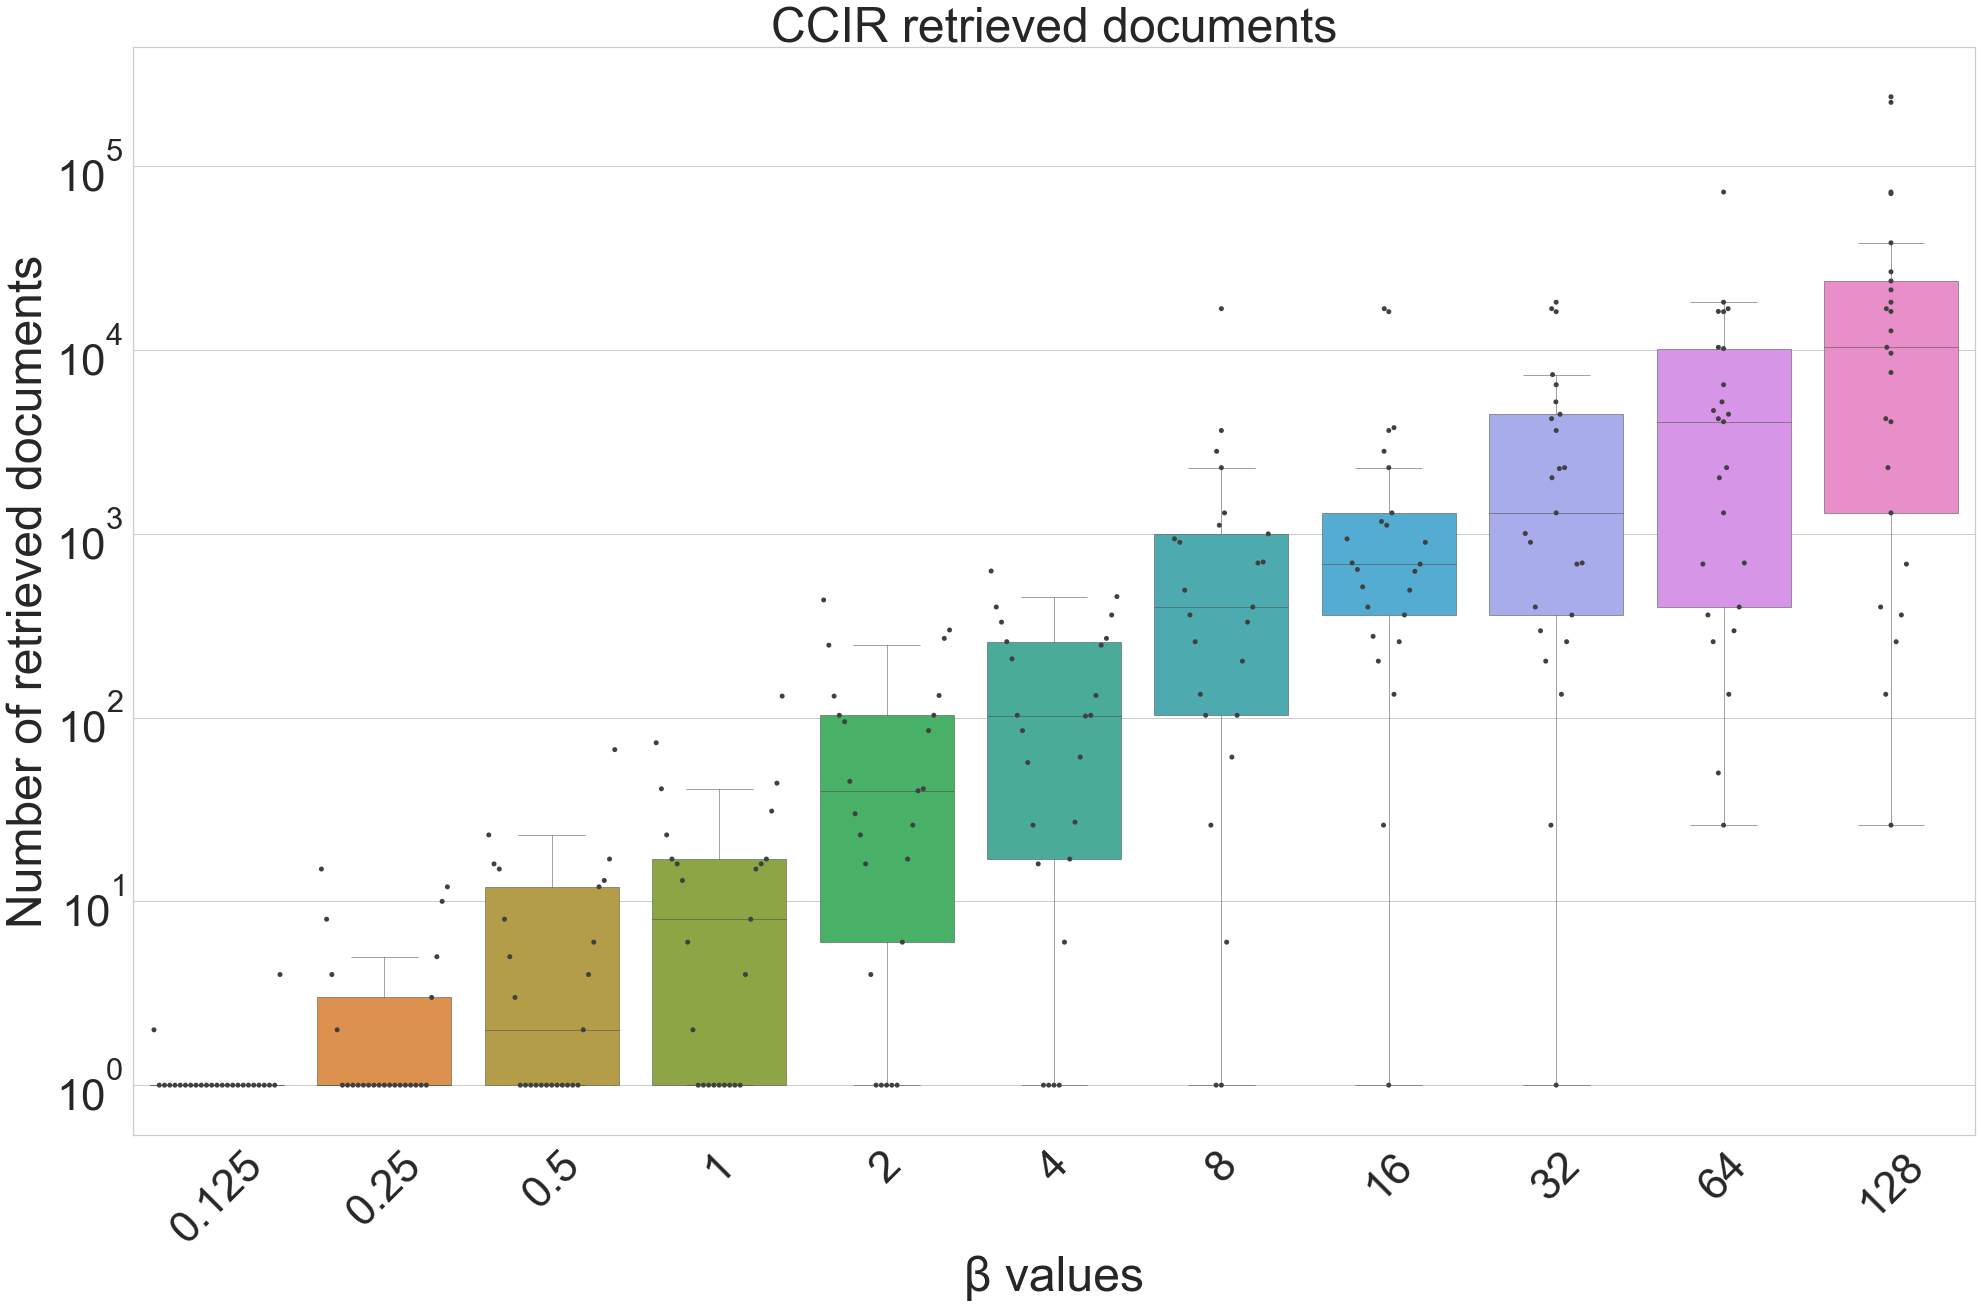

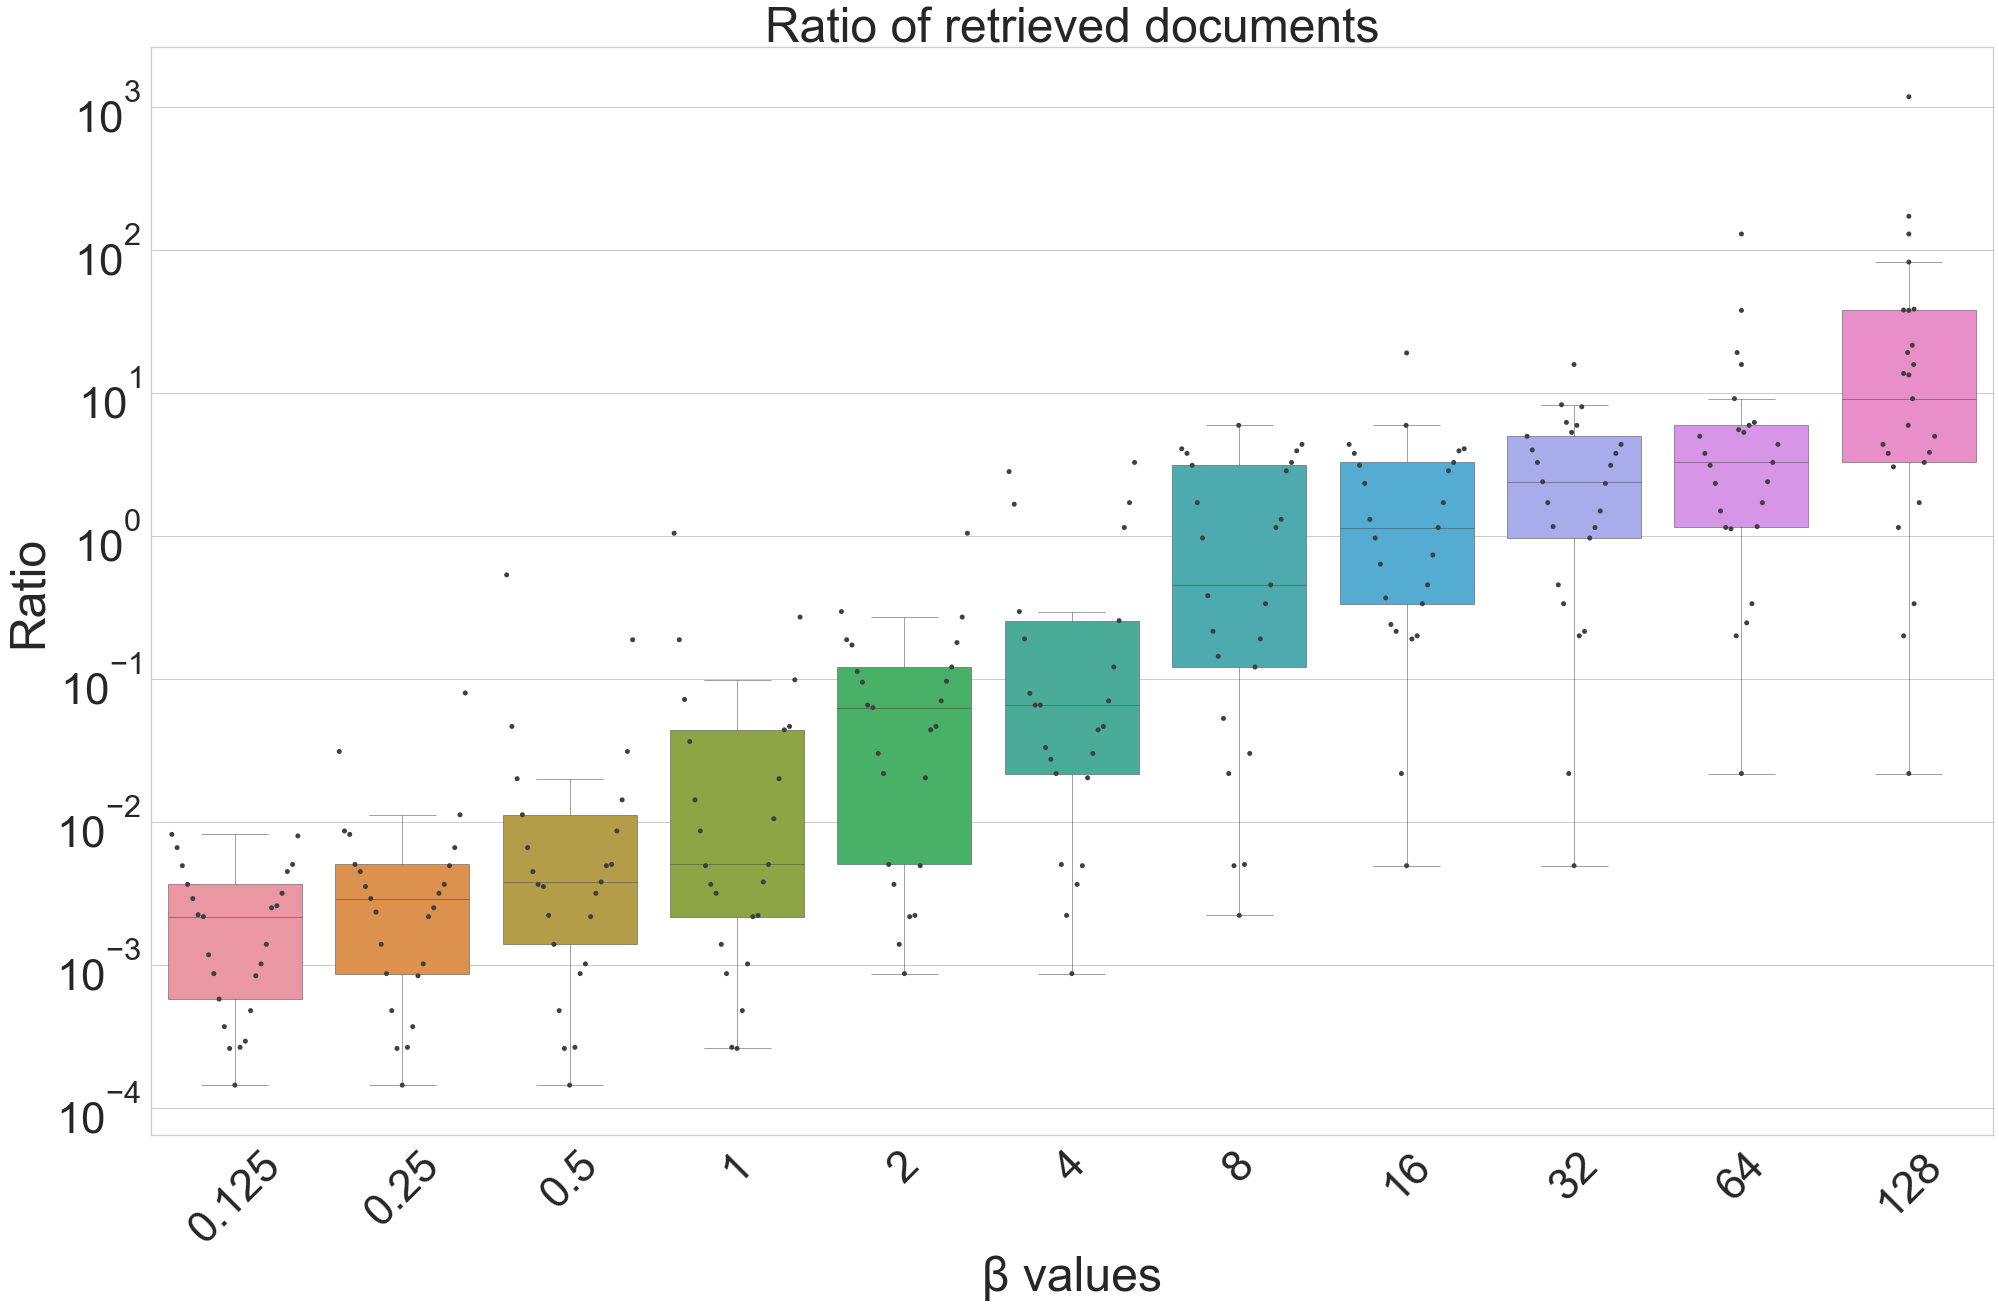

In [52]:

metric = 'boolean_retrieved'
beta_name = 'by_beta_0.125'
data = t_d[beta_name][metric]
plot_Boxplot_Horizontal_Break(data, suptitle='Boolean query retrieved documents', set_xlabel='Number of documents', ticks=False, font_scale=3, set_xlim_ax1=(0, 4500), set_xlim_ax2=(6900, 7000), figsize=(20, 4))

metric = 'scimacro_retrieved'
plot_Series_Of_Boxplots([t_d[beta_name][metric] for beta_name in beta_name_l], 
                        set_title='CCIR retrieved documents', set_ylabel='Number of retrieved documents', set_yscale='log', font_scale=4, figsize=(33, 20))


metric = 'scimacro_retrieved_over_boolean'
plot_Series_Of_Boxplots([t_d[beta_name][metric] for beta_name in beta_name_l], 
                        set_title='Ratio of retrieved documents', set_ylabel='Ratio',
                        set_yscale='log', font_scale=4, figsize=(33, 20))



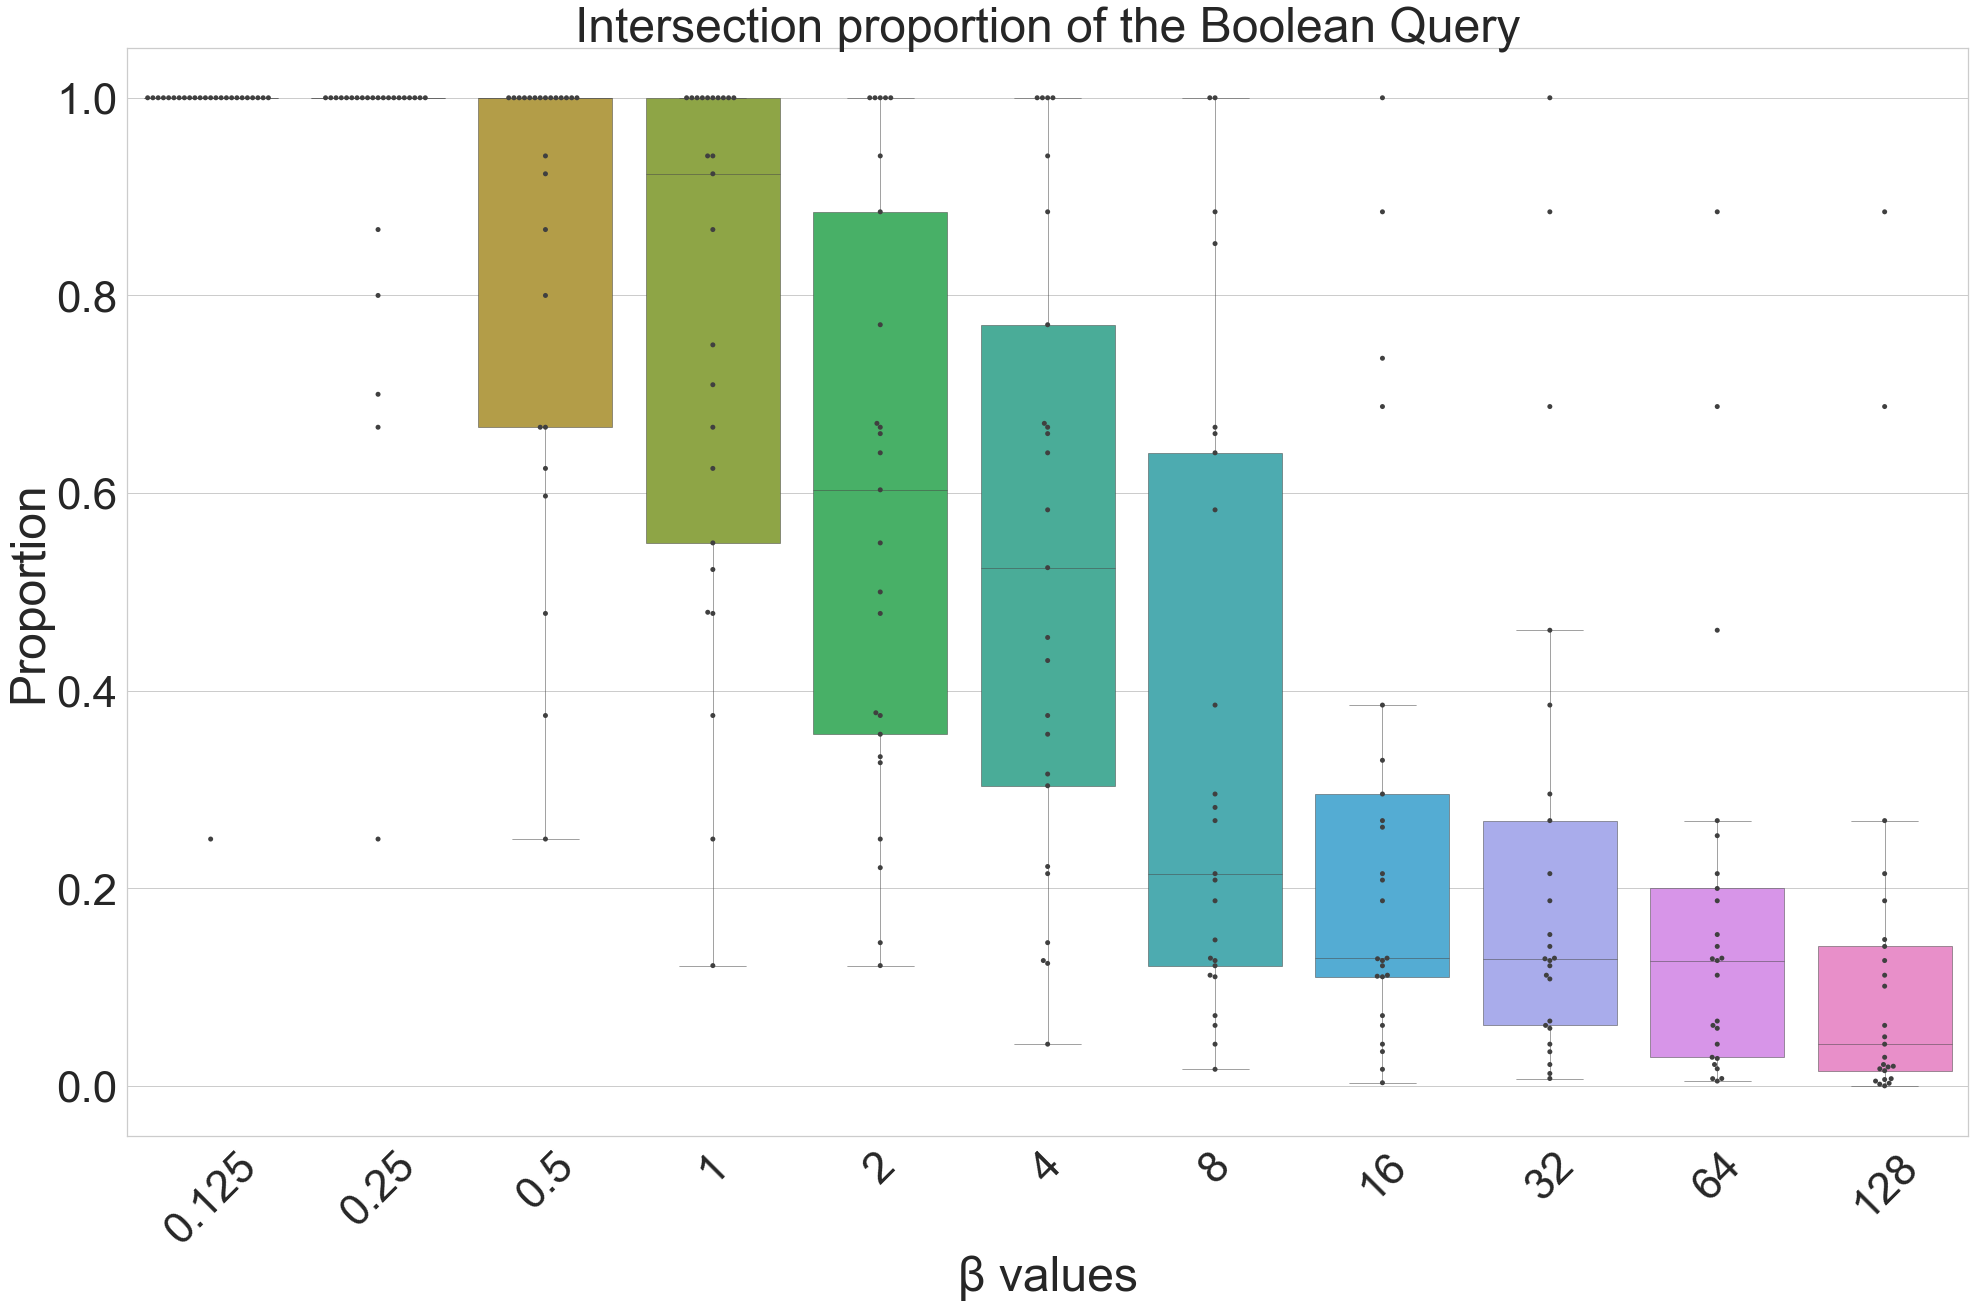

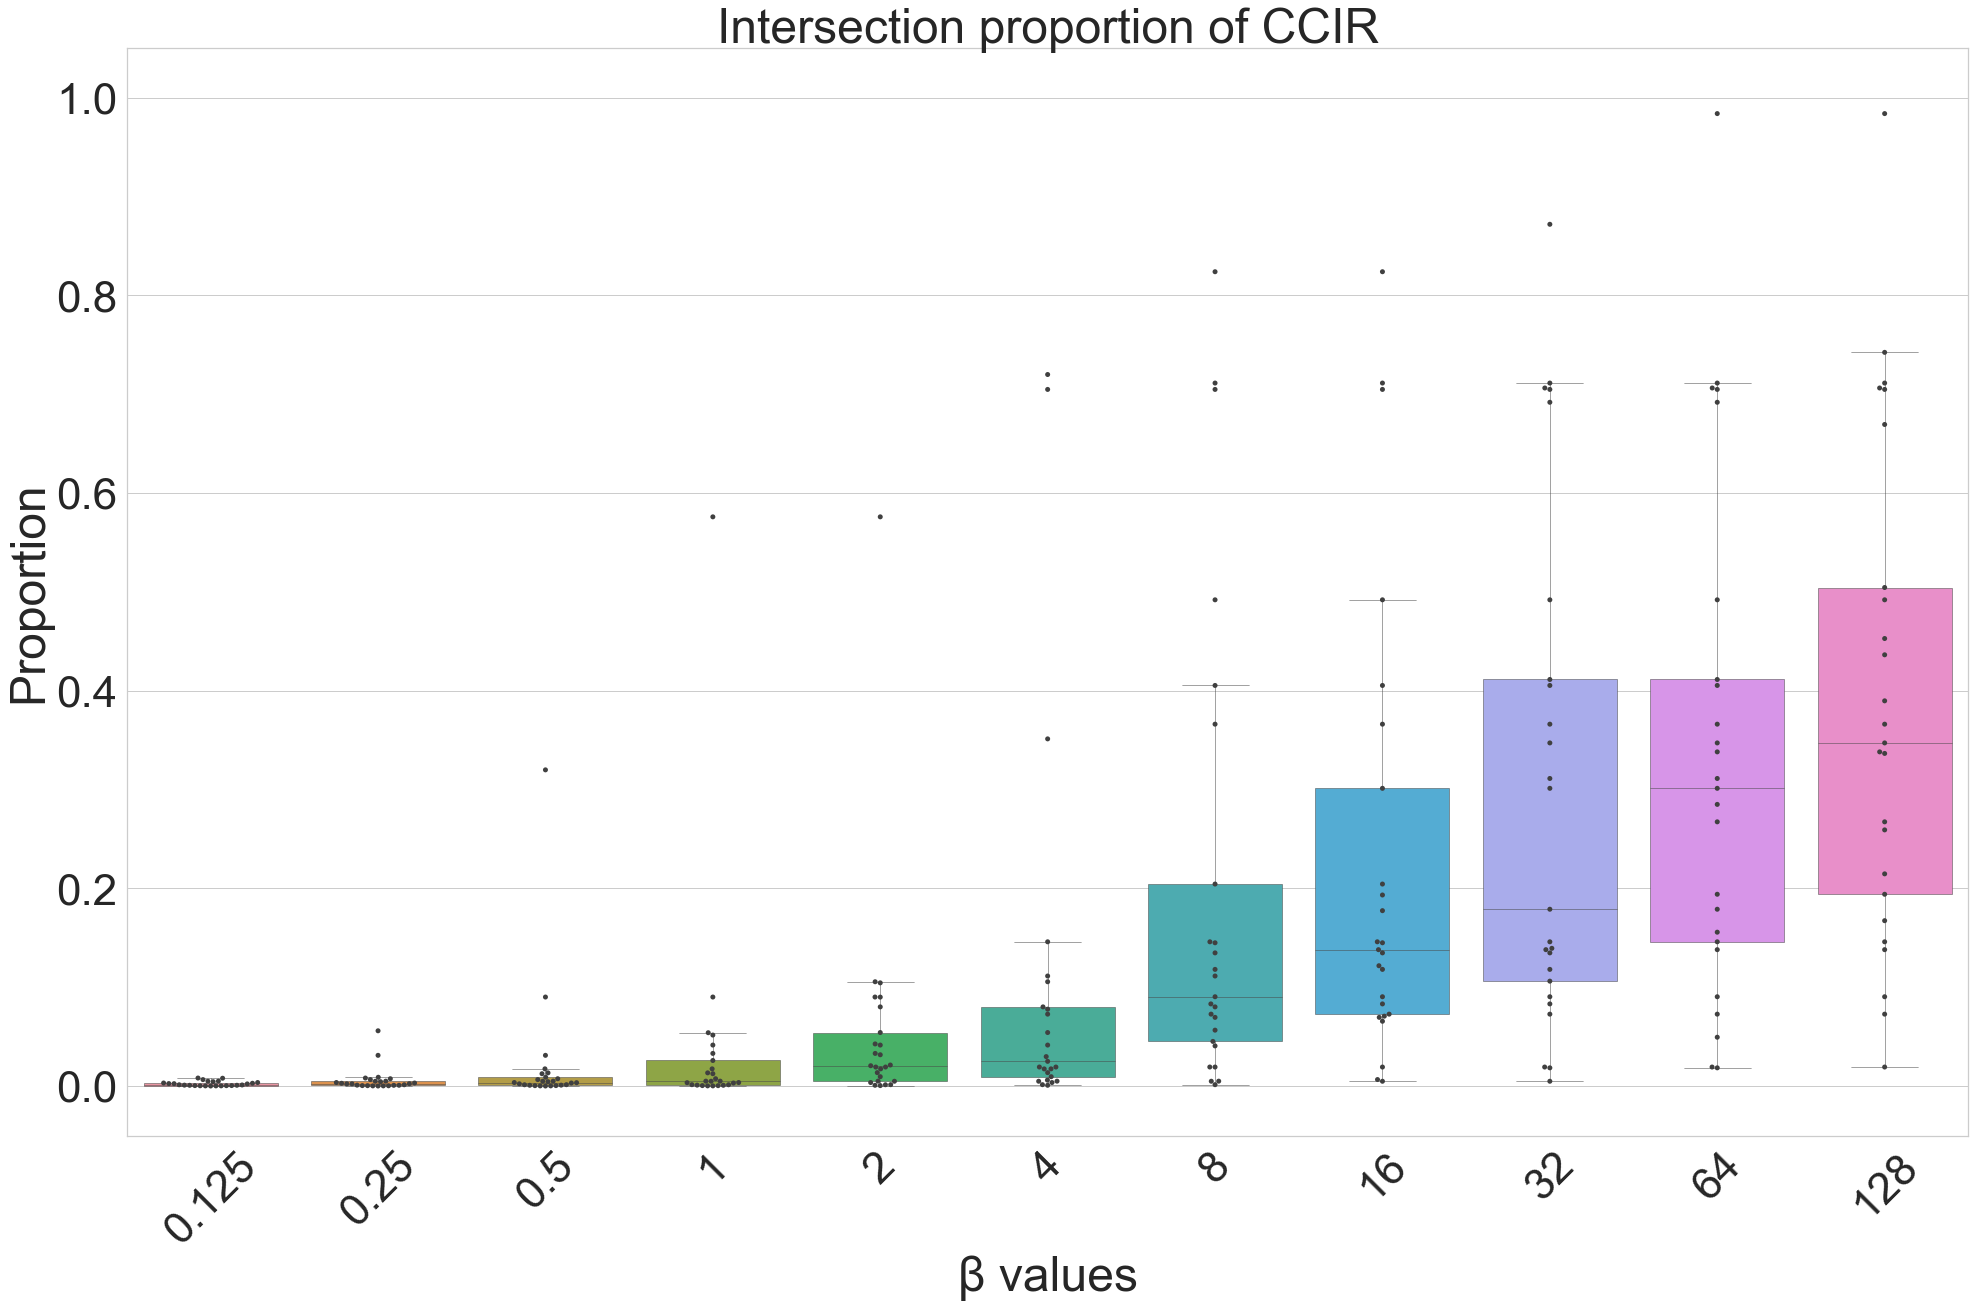

In [53]:
metric = 'retrieved_intersection_over_scimacro'
plot_Series_Of_Boxplots([t_d[beta_name][metric] for beta_name in beta_name_l],
                        set_title='Intersection proportion of the Boolean Query', set_ylabel='Proportion', ylim=(-0.05, 1.05), font_scale=4, figsize=(33, 20))

metric = 'retrieved_intersection_over_boolean'
plot_Series_Of_Boxplots([t_d[beta_name][metric] for beta_name in beta_name_l],
                        set_title='Intersection proportion of CCIR', set_ylabel='Proportion', ylim=(-0.05, 1.05), font_scale=4, figsize=(33, 20))


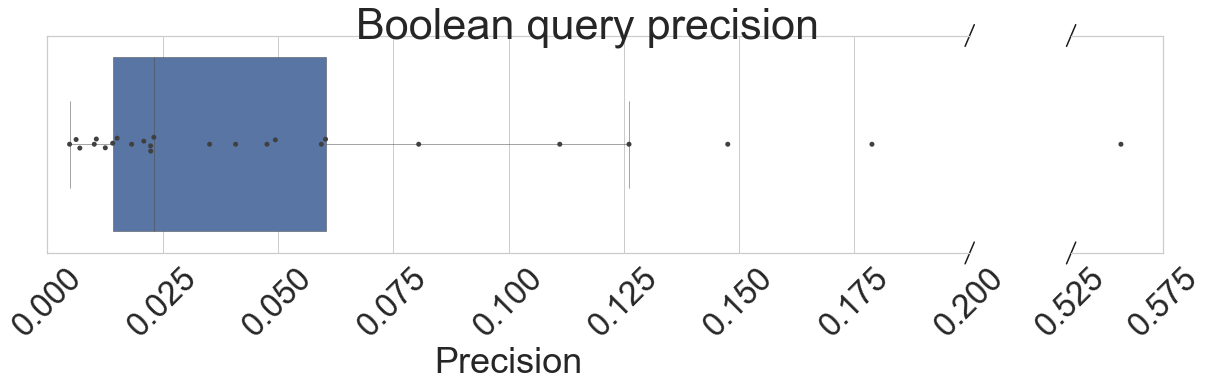

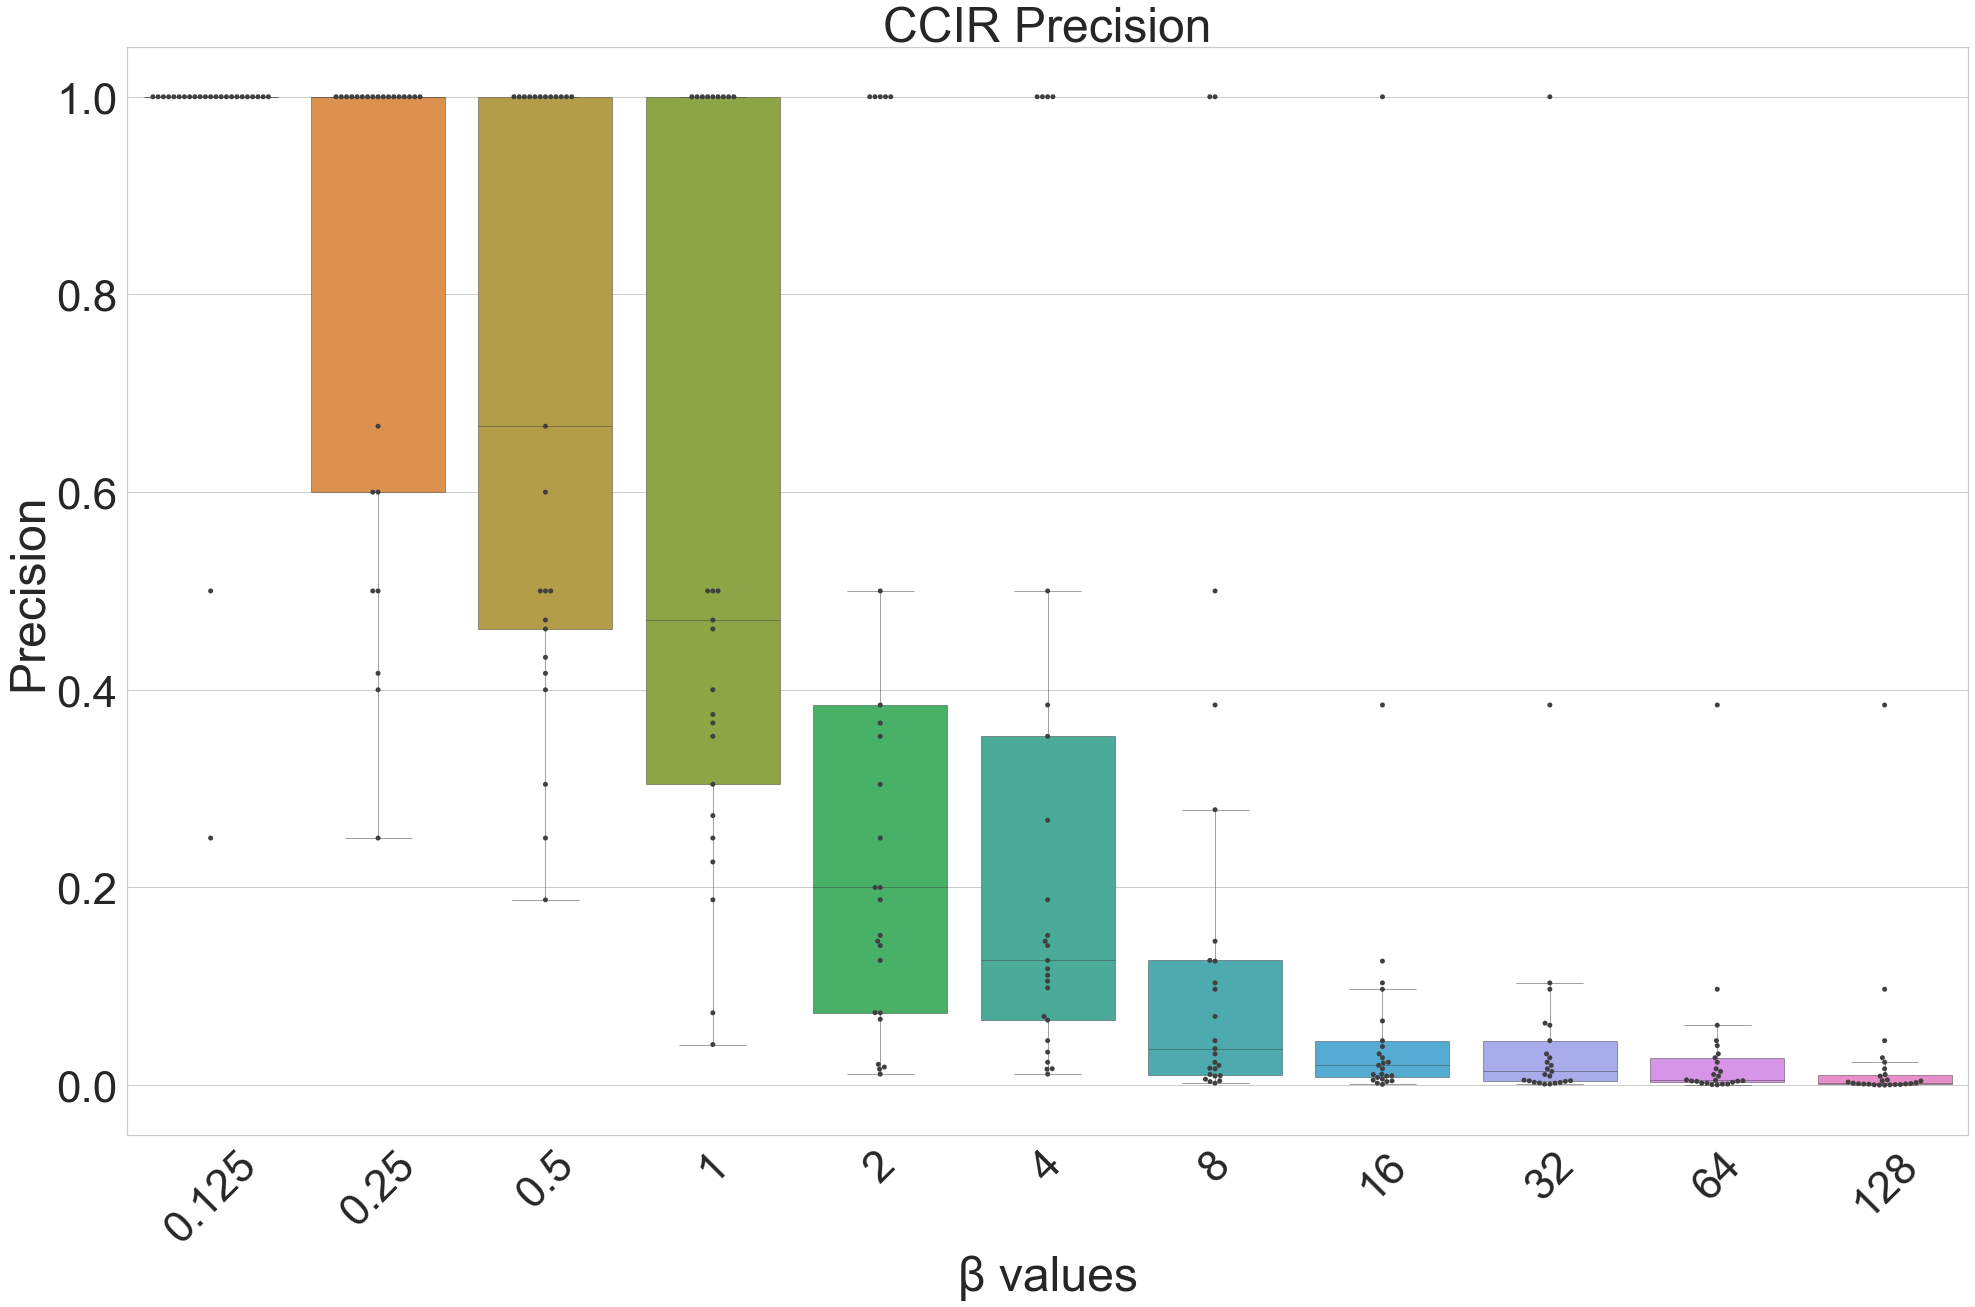

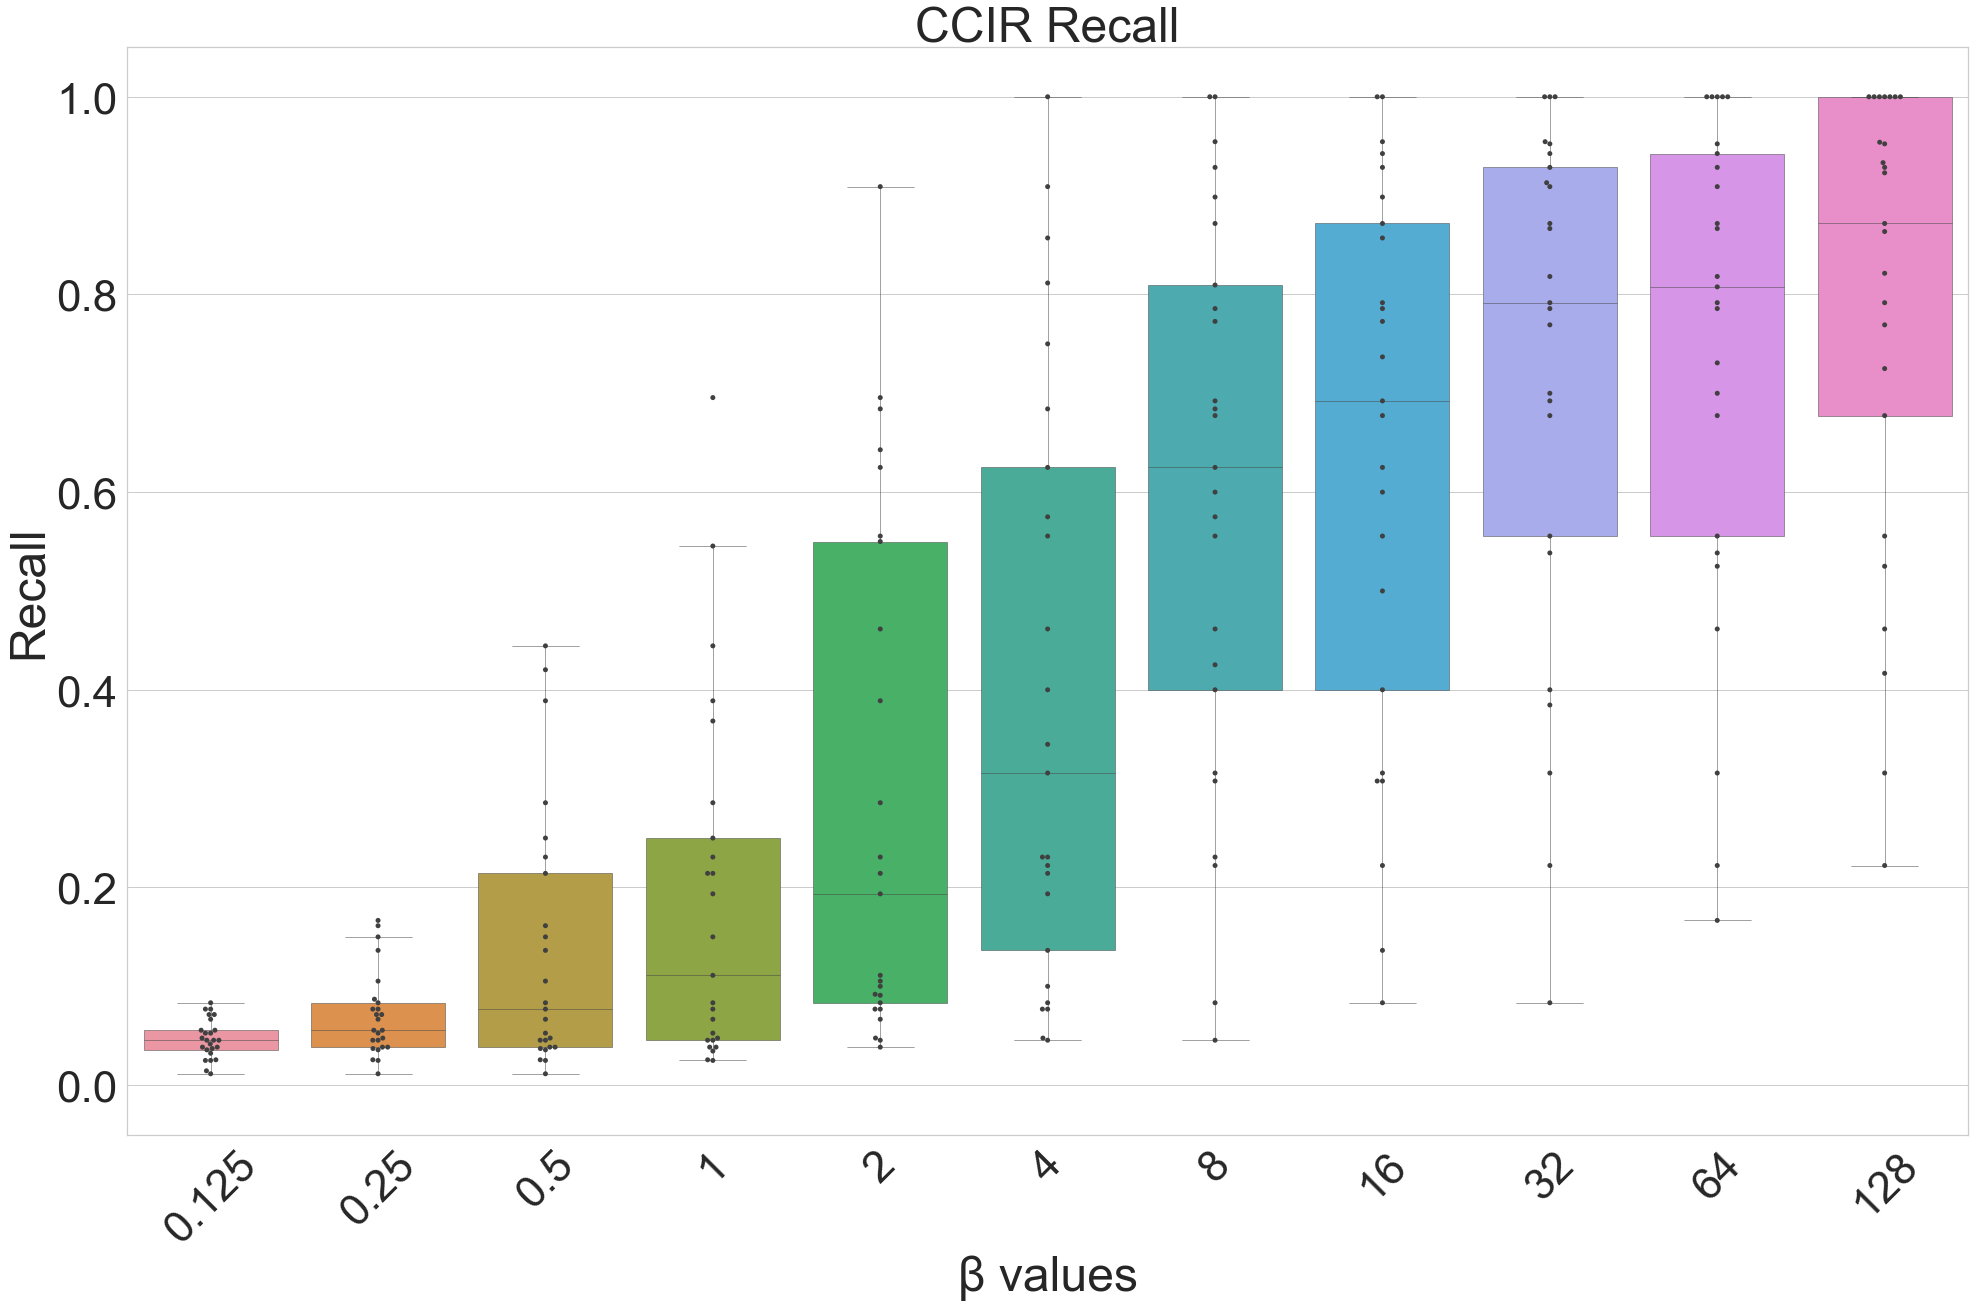

In [ ]:
metric = 'boolean_precision'
beta_name = 'by_beta_0.125'
data = t_d[beta_name][metric]
plot_Boxplot_Horizontal_Break(data, suptitle='Boolean query precision', set_xlabel='Precision', ticks=False, font_scale=3, set_xlim_ax1=(0, 0.2), set_xlim_ax2=(0.525, 0.575), figsize=(20, 4))

metric = 'scimacro_precision'
plot_Series_Of_Boxplots([t_d[beta_name][metric] for beta_name in beta_name_l], set_title='CCIR Precision', set_ylabel='Precision', ylim=(-0.05, 1.05), font_scale=4, figsize=(33, 20))

metric = 'scimacro_recall'
plot_Series_Of_Boxplots([t_d[beta_name][metric] for beta_name in beta_name_l], set_title='CCIR Recall', set_ylabel='Recall', ylim=(-0.05, 1.05), font_scale=4, figsize=(33, 20))

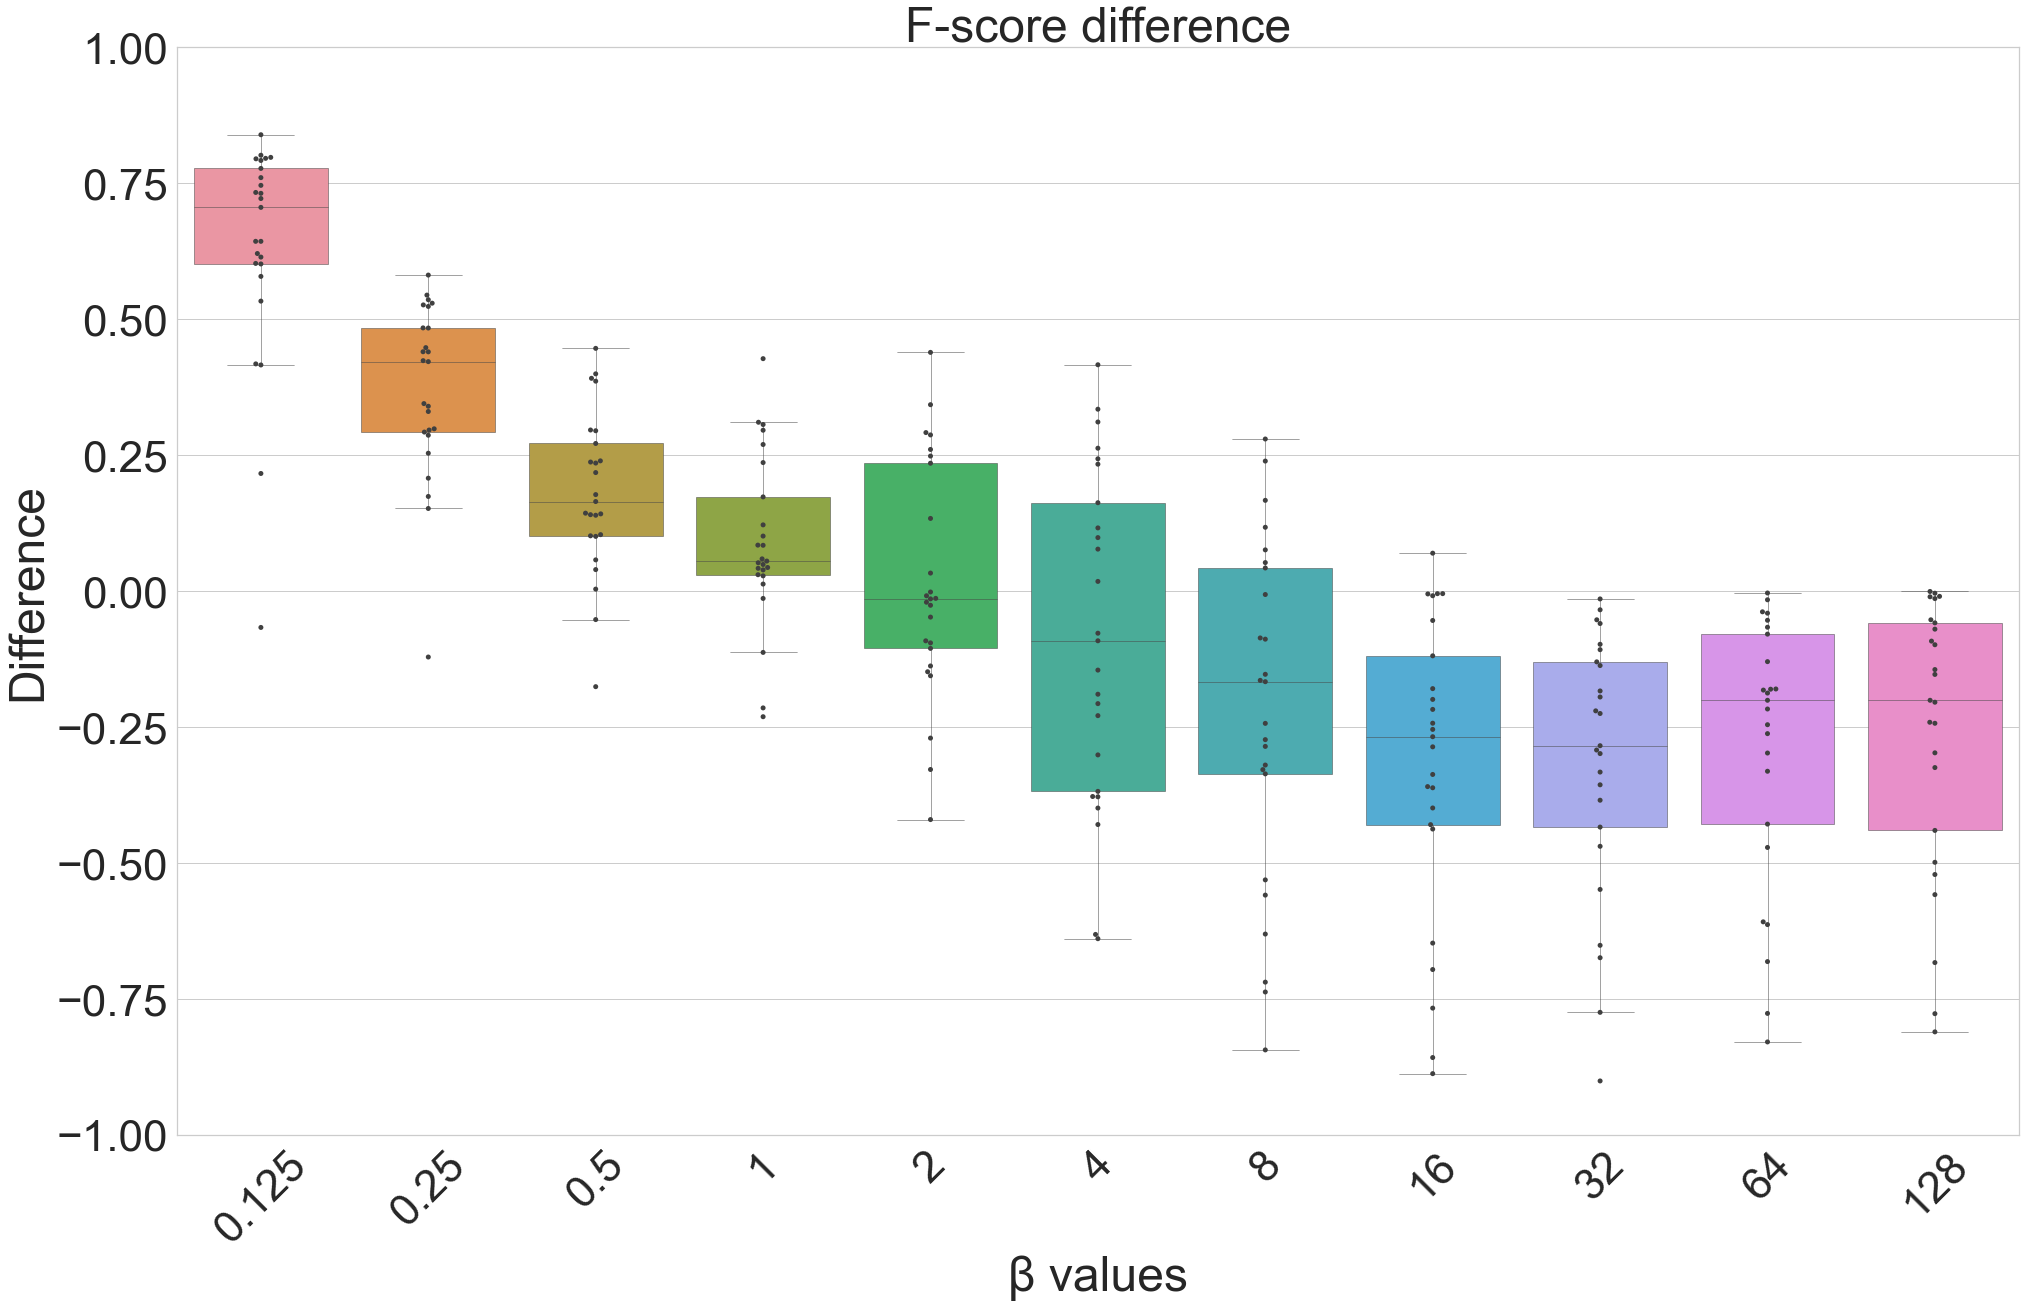

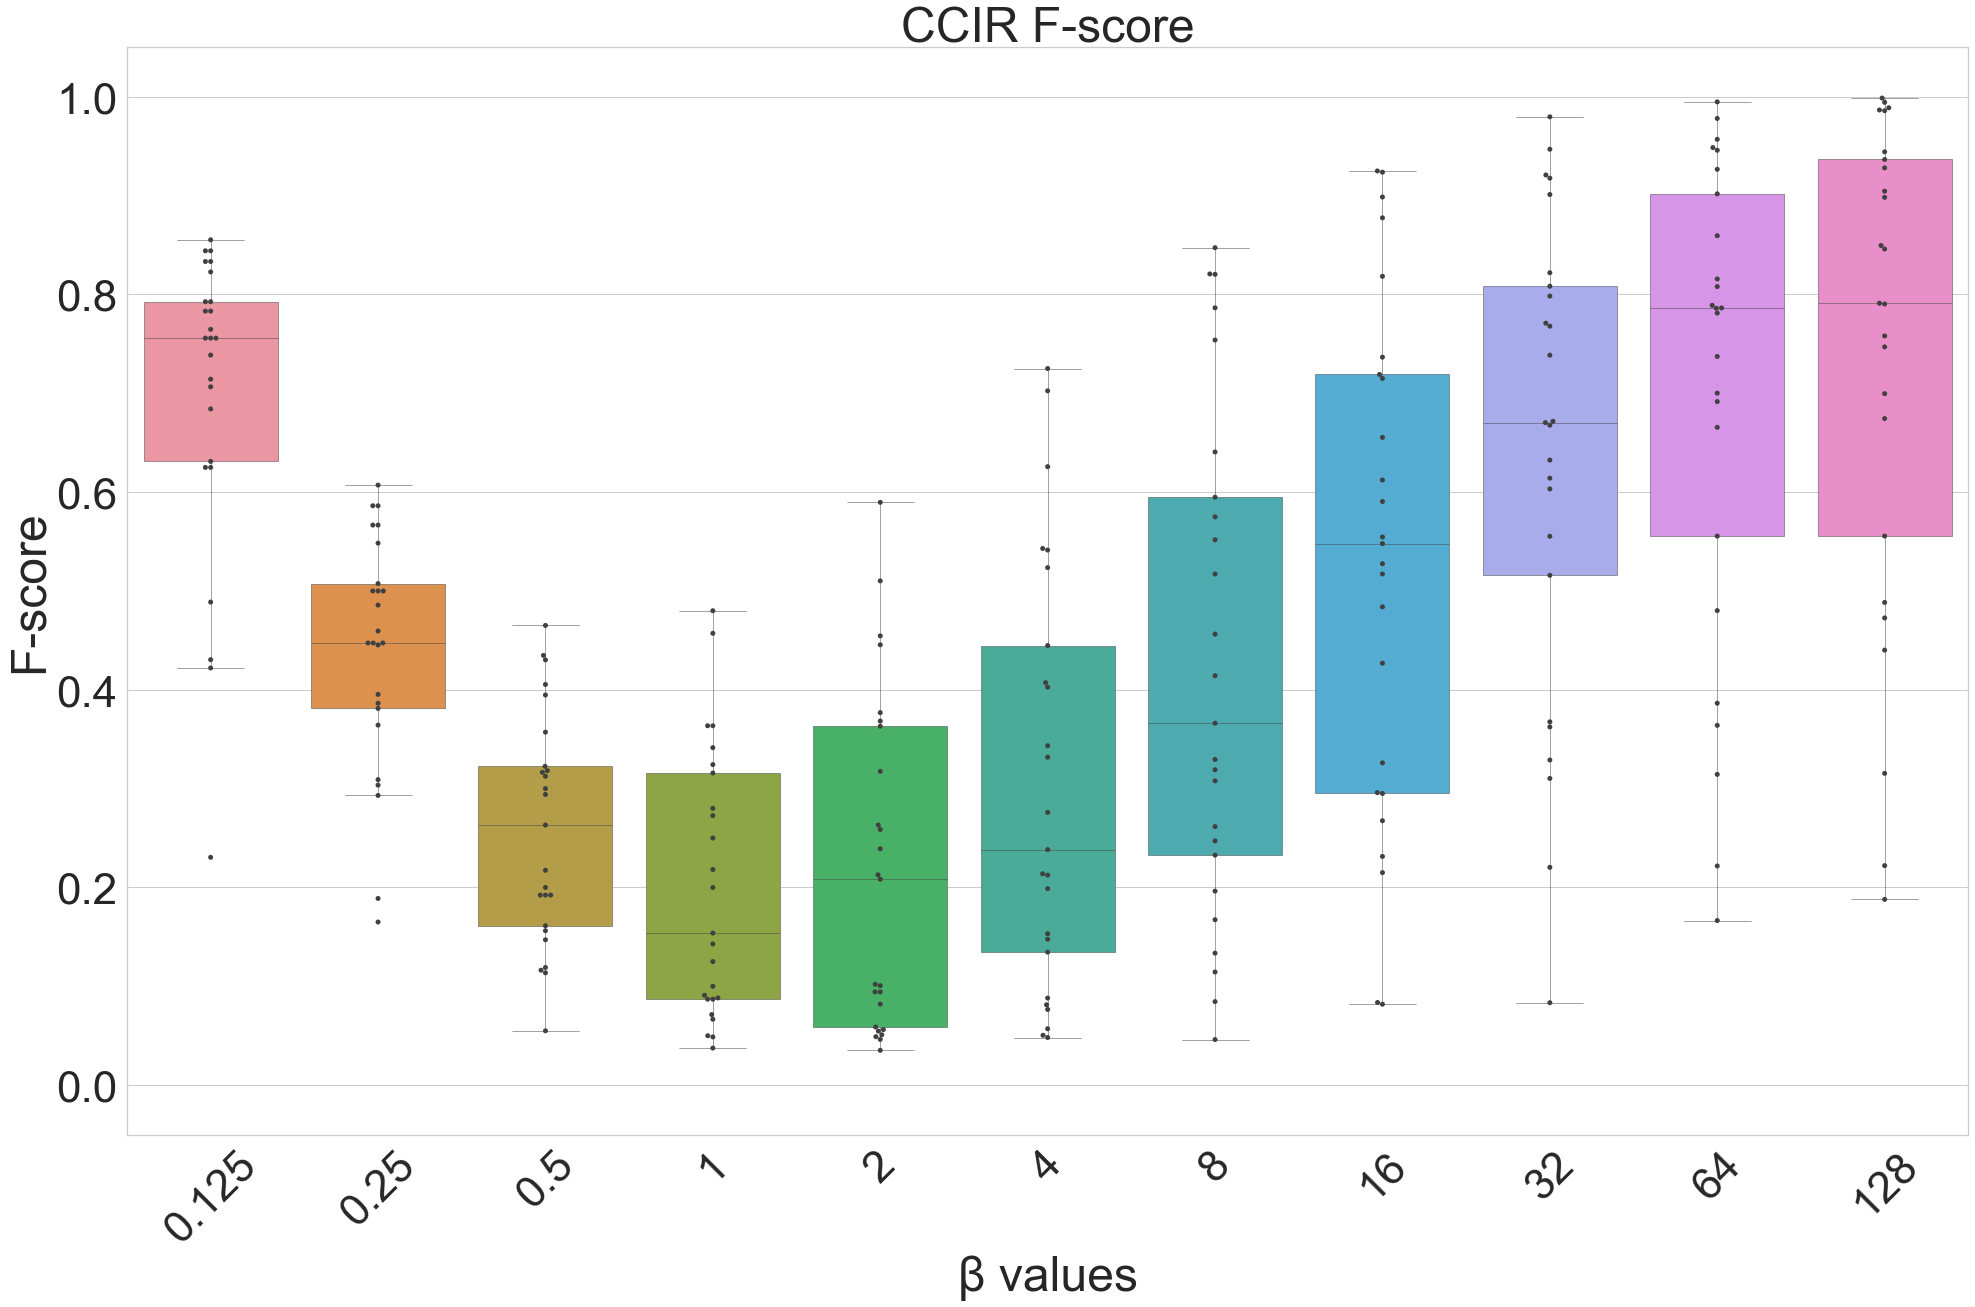

In [55]:
metric = 'fscore_dif'
plot_Series_Of_Boxplots([t_d[beta_name][metric] for beta_name in beta_name_l], 
                        set_title='F-score difference', set_ylabel='Difference', ylim=(-1, 1), font_scale=4, figsize=(33, 20))

metric = 'scimacro_fscore'
plot_Series_Of_Boxplots([t_d[beta_name][metric] for beta_name in beta_name_l], 
                        set_title='CCIR F-score', set_ylabel='F-score', ylim=(-0.05, 1.05), font_scale=4, figsize=(33, 20))

In [18]:
metrics_noyear_d = {}
for year in metrics_d:
    for topic in metrics_d[year]:
        metrics_noyear_d[topic] = metrics_d[year][topic]
        
#  I will use the beta 4.0 for selecting the most interesting systematic reviews
#  because 4.0 has the most diversity

# ratio is the ratio between the number of reported retrieved papers by the authors and the number of retrieved papers by pubmed
        
by_beta = 'by_beta_4.0'

performance_l = []
for topic in metrics_noyear_d:
    scimacro_fscore = metrics_noyear_d[topic]['betas'][by_beta]['scimacro_fscore']
    boolean_fscore = metrics_noyear_d[topic]['betas'][by_beta]['boolean_fscore']
    difference = scimacro_fscore - boolean_fscore
    n_reported_retrieved_papers = topic_sr_data_d[topic]['retrieved']
    n_boolean_retrieved_papers = len(metrics_noyear_d[topic]['boolean_retrieved_ids'])
    if n_reported_retrieved_papers is not None:
        ratio = n_reported_retrieved_papers / n_boolean_retrieved_papers
    else:
        ratio = None
    performance_l.append((topic, difference, ratio))
    
print(sorted(performance_l, key=lambda x: x[1]))

[(59, -0.6396948762948271, 3.9139072847682117), (155, -0.6318413597733712, 3.7474747474747474), (13, -0.4296835959075248, 10.148514851485148), (173, -0.3993534725956017, 1.0285714285714285), (136, -0.3786633745769294, 1.1126126126126126), (93, -0.37811974654079916, 0.3333333333333333), (12, -0.36865621679838156, 7.282539682539682), (79, -0.301574021554169, 7.565573770491803), (119, -0.22937737849644013, 1.048), (151, -0.20725308641975312, 2.2448979591836733), (46, -0.1899589365464736, 3.1688424717145343), (51, -0.14558516893461004, 9.843336724313327), (78, -0.0916410667814585, 0.19921773142112126), (169, -0.07772340073225027, 1.0353066100345103), (69, 0.01756649574941077, 5.834967320261438), (89, 0.07697666318355978, 11.8884239888424), (1, 0.09816686079008755, 3.5099624602945423), (124, 0.11599974296764692, 5.530600461893765), (11, 0.1623205080409827, 0.6651851851851852), (6, 0.23321961487810694, 1.09438202247191), (105, 0.24313021521709105, 3.5050251256281406), (55, 0.2626155985530986

In [29]:
# Qualitative analysis 
year = 2015
topic = 59
for beta in metrics_d[year][topic]['betas'].keys():
    print(beta)
    print(len(metrics_d[year][topic]['betas'][beta]['scimacro_true_positive_ids']))
    print(metrics_d[year][topic]['betas'][beta]['scimacro_precision'])

positives = set(clean_ref[year][topic]['positives_retrieved_in_net'])
b_retrieved = set(clean_ref[year][topic]['retrieved_in_net'])

beta = 'by_beta_1.0'
s_retrieved = set(metrics_d[year][topic]['betas'][beta]['scimacro_retrieved_ids'])
topic_59_beta1 = Topic_Retrieve_Data(positives, b_retrieved, s_retrieved)

selected_beta = 'by_beta_4.0'
s_retrieved = set(metrics_d[year][topic]['betas'][selected_beta]['scimacro_retrieved_ids'])
topic_59_beta4 = Topic_Retrieve_Data(positives, b_retrieved, s_retrieved)


year = 2016
topic = 47
for beta in metrics_d[year][topic]['betas'].keys():
    print(beta)
    print(len(metrics_d[year][topic]['betas'][beta]['scimacro_true_positive_ids']))
    print(metrics_d[year][topic]['betas'][beta]['scimacro_precision'])
    
positives = set(clean_ref[year][topic]['positives_retrieved_in_net'])
b_retrieved = set(clean_ref[year][topic]['retrieved_in_net'])

beta = 'by_beta_2.0'
s_retrieved = set(metrics_d[year][topic]['betas'][beta]['scimacro_retrieved_ids'])
topic_47_beta2 = Topic_Retrieve_Data(positives, b_retrieved, s_retrieved)

selected_beta = 'by_beta_16.0'
s_retrieved = set(metrics_d[year][topic]['betas'][selected_beta]['scimacro_retrieved_ids'])
topic_47_beta16 = Topic_Retrieve_Data(positives, b_retrieved, s_retrieved)

year = 2015
topic = 80
for beta in metrics_d[year][topic]['betas'].keys():
    print(beta)
    print(len(metrics_d[year][topic]['betas'][beta]['scimacro_true_positive_ids']))
    print(metrics_d[year][topic]['betas'][beta]['scimacro_precision'])
    
positives = set(clean_ref[year][topic]['positives_retrieved_in_net'])
b_retrieved = set(clean_ref[year][topic]['retrieved_in_net'])

beta = 'by_beta_2.0'
s_retrieved = set(metrics_d[year][topic]['betas'][beta]['scimacro_retrieved_ids'])
topic_80_beta2 = Topic_Retrieve_Data(positives, b_retrieved, s_retrieved)

selected_beta = 'by_beta_8.0'
s_retrieved = set(metrics_d[year][topic]['betas'][selected_beta]['scimacro_retrieved_ids'])
topic_80_beta8 = Topic_Retrieve_Data(positives, b_retrieved, s_retrieved)

print('topic_59_beta1')
cluster_Stats(topic_59_beta1)
print()
print('topic_59_beta4')
cluster_Stats(topic_59_beta4)
print()
print('topic_47_beta2')
cluster_Stats(topic_47_beta2)
print()
print('topic_47_beta16')
cluster_Stats(topic_47_beta16)
print()
print('topic_80_beta2')
cluster_Stats(topic_80_beta2)
print()
print('topic_80_beta8')
cluster_Stats(topic_80_beta8)
print()

by_beta_0.125
1
1.0
by_beta_0.25
1
1.0
by_beta_0.5
1
1.0
by_beta_1.0
3
0.07317073170731707
by_beta_2.0
3
0.07317073170731707
by_beta_4.0
6
0.023166023166023165
by_beta_8.0
6
0.023166023166023165
by_beta_16.0
6
0.023166023166023165
by_beta_32.0
6
0.023166023166023165
by_beta_64.0
6
0.023166023166023165
by_beta_128.0
6
0.023166023166023165
by_beta_0.125
1
1.0
by_beta_0.25
4
0.5
by_beta_0.5
6
0.46153846153846156
by_beta_1.0
6
0.46153846153846156
by_beta_2.0
15
0.14563106796116504
by_beta_4.0
15
0.14563106796116504
by_beta_8.0
15
0.14563106796116504
by_beta_16.0
19
0.027737226277372264
by_beta_32.0
19
0.027737226277372264
by_beta_64.0
19
0.027737226277372264
by_beta_128.0
19
0.027737226277372264
by_beta_0.125
1
0.5
by_beta_0.25
1
0.5
by_beta_0.5
1
0.5
by_beta_1.0
1
0.5
by_beta_2.0
12
0.1411764705882353
by_beta_4.0
12
0.1411764705882353
by_beta_8.0
18
0.02
by_beta_16.0
18
0.02
by_beta_32.0
18
0.02
by_beta_64.0
19
0.0040494458653026425
by_beta_128.0
20
0.0015704750687082843
topic_59_beta1
b_

59


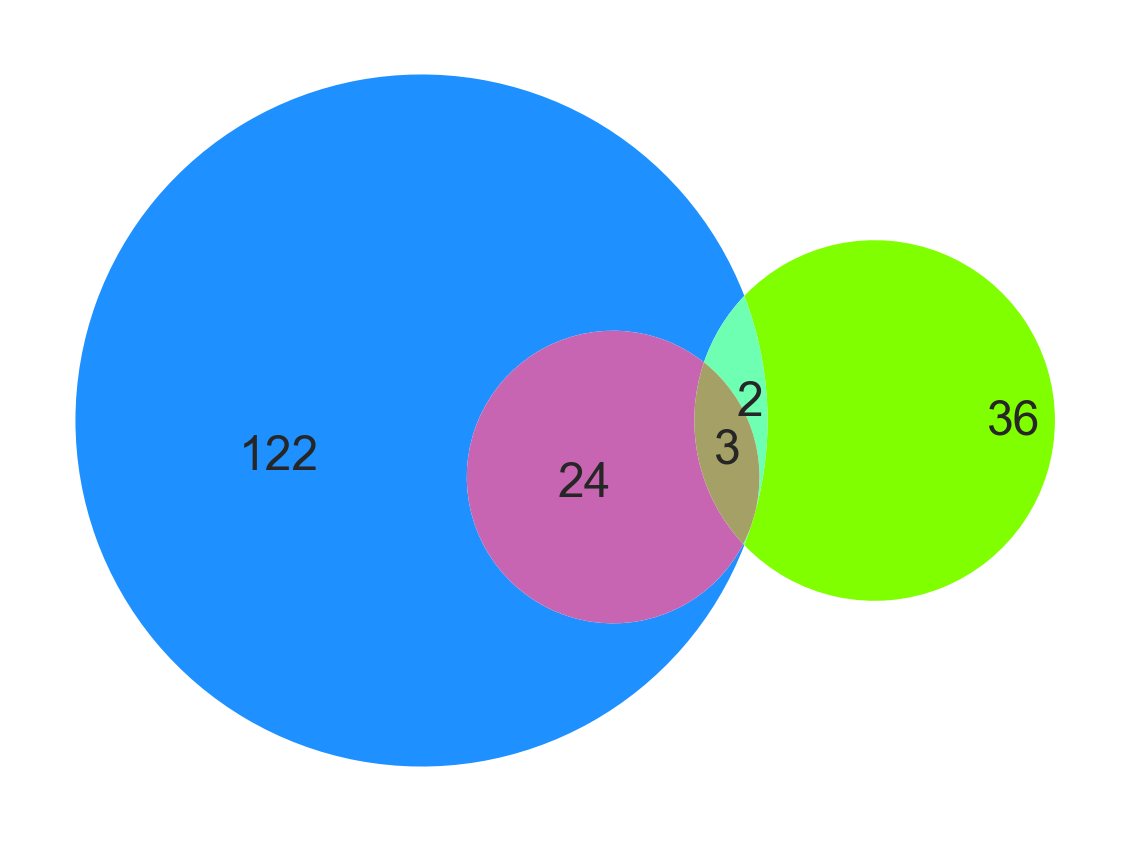

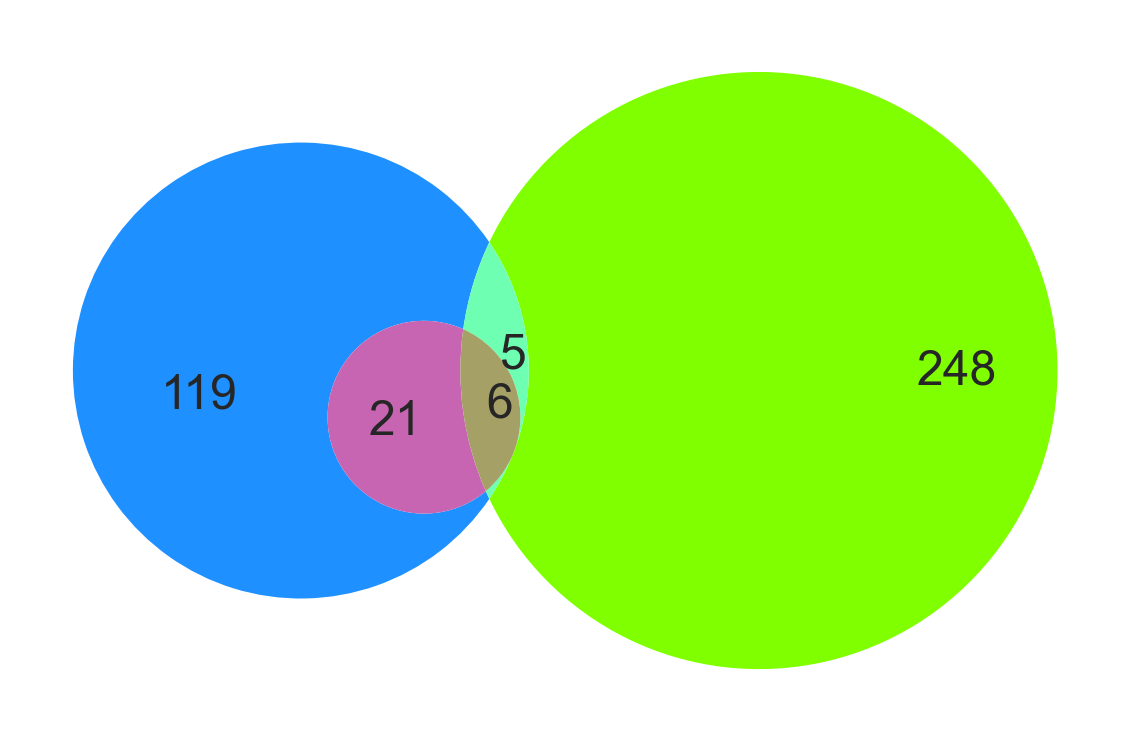

47


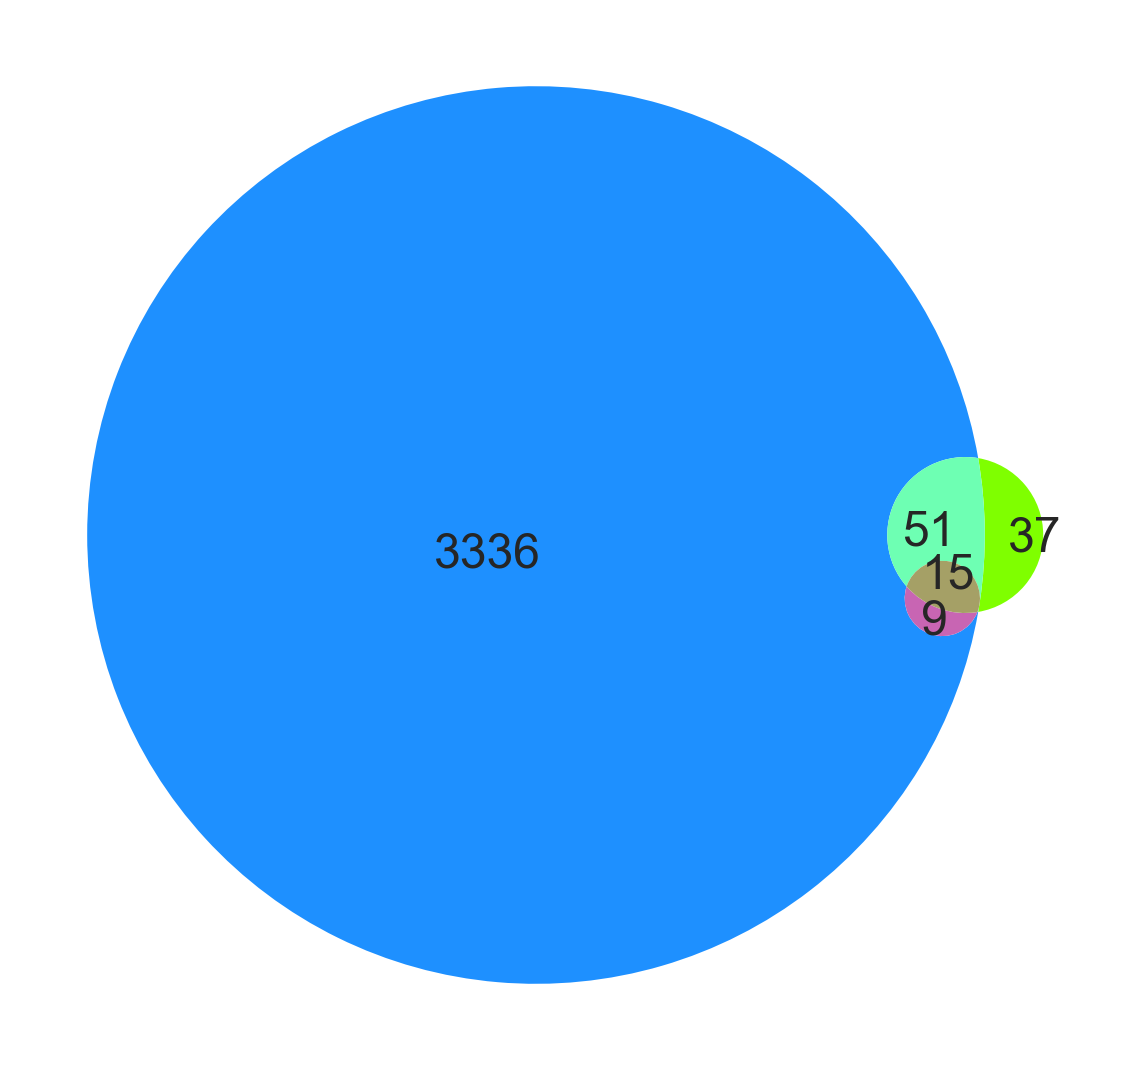

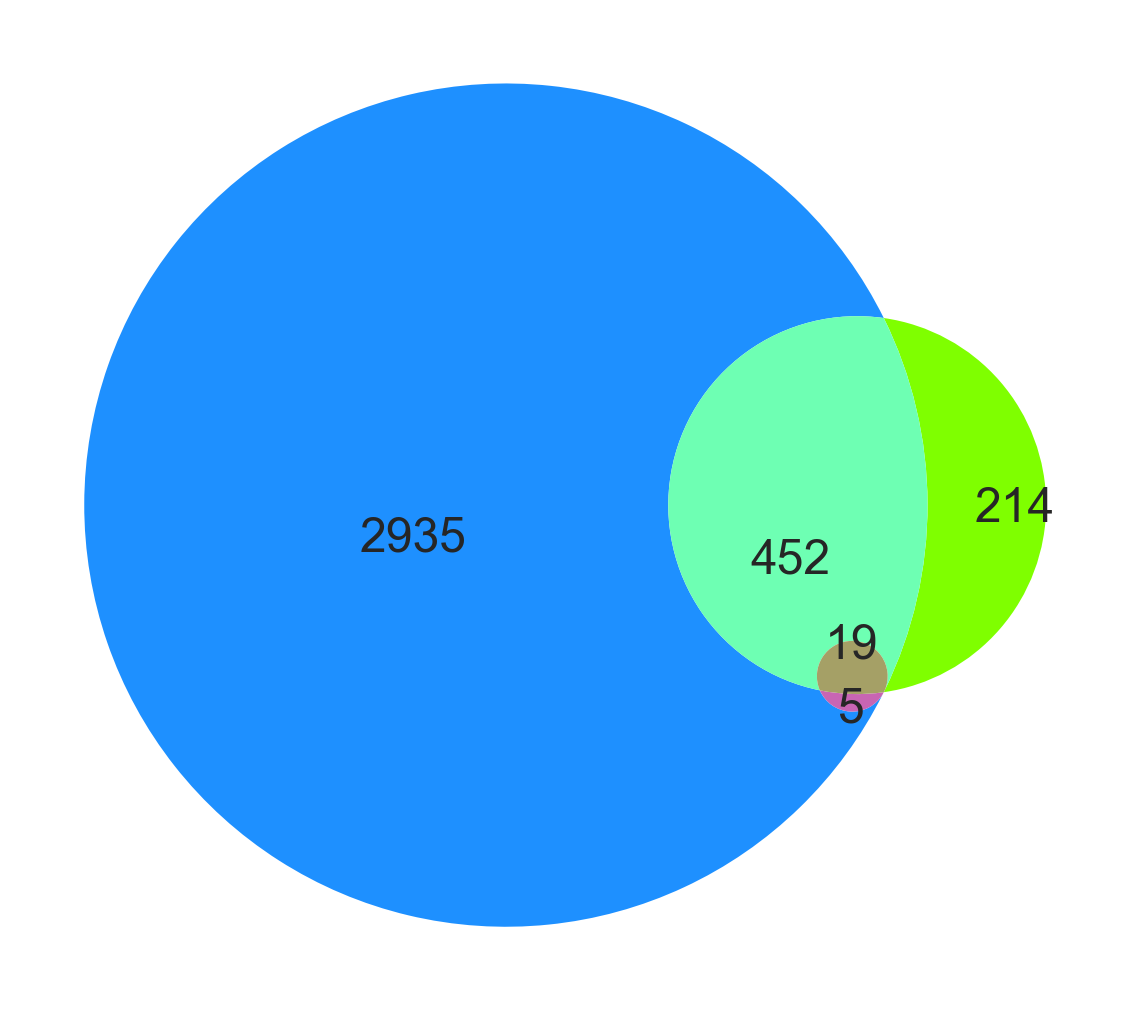

80


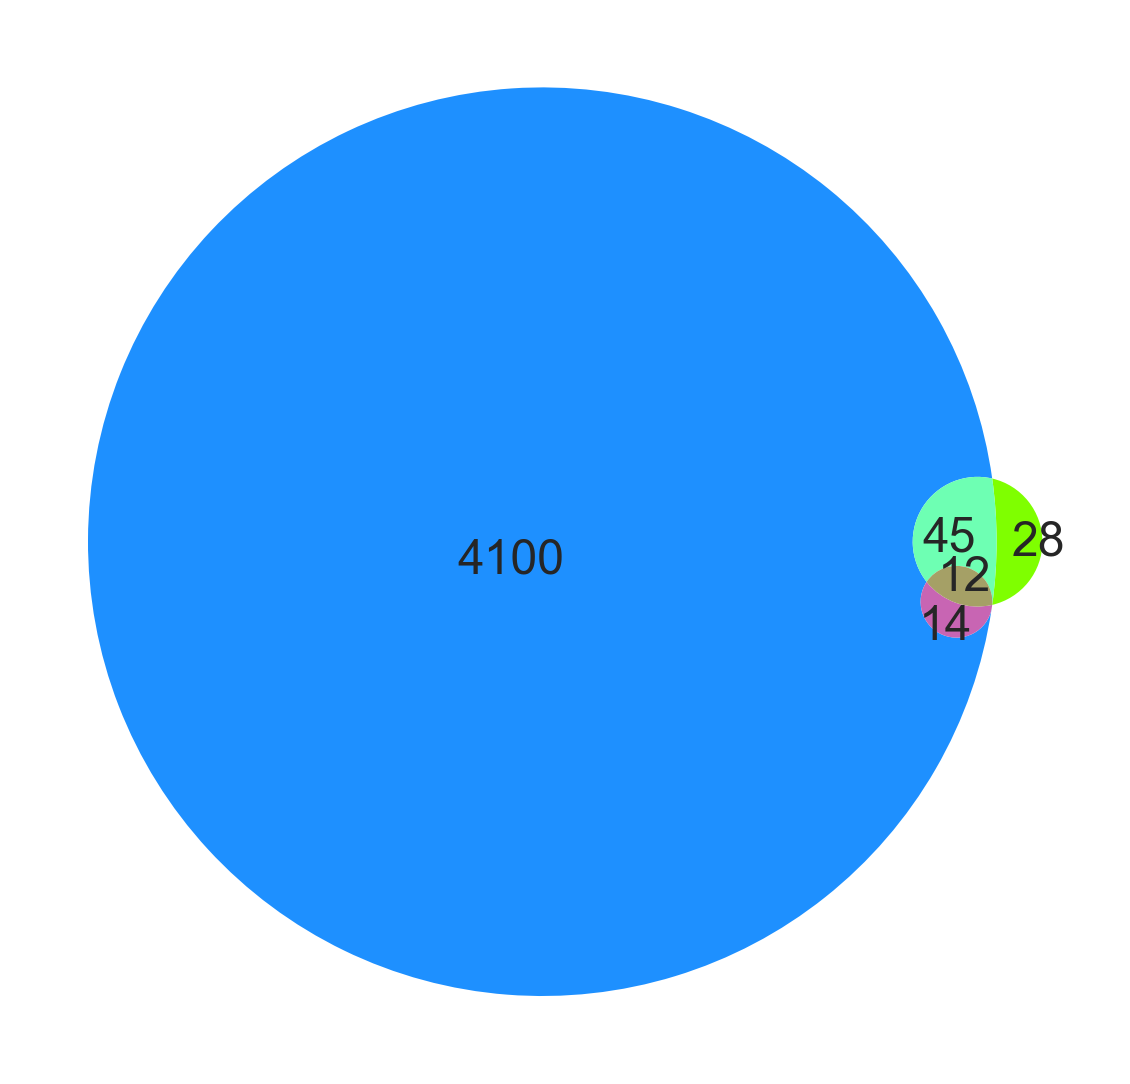

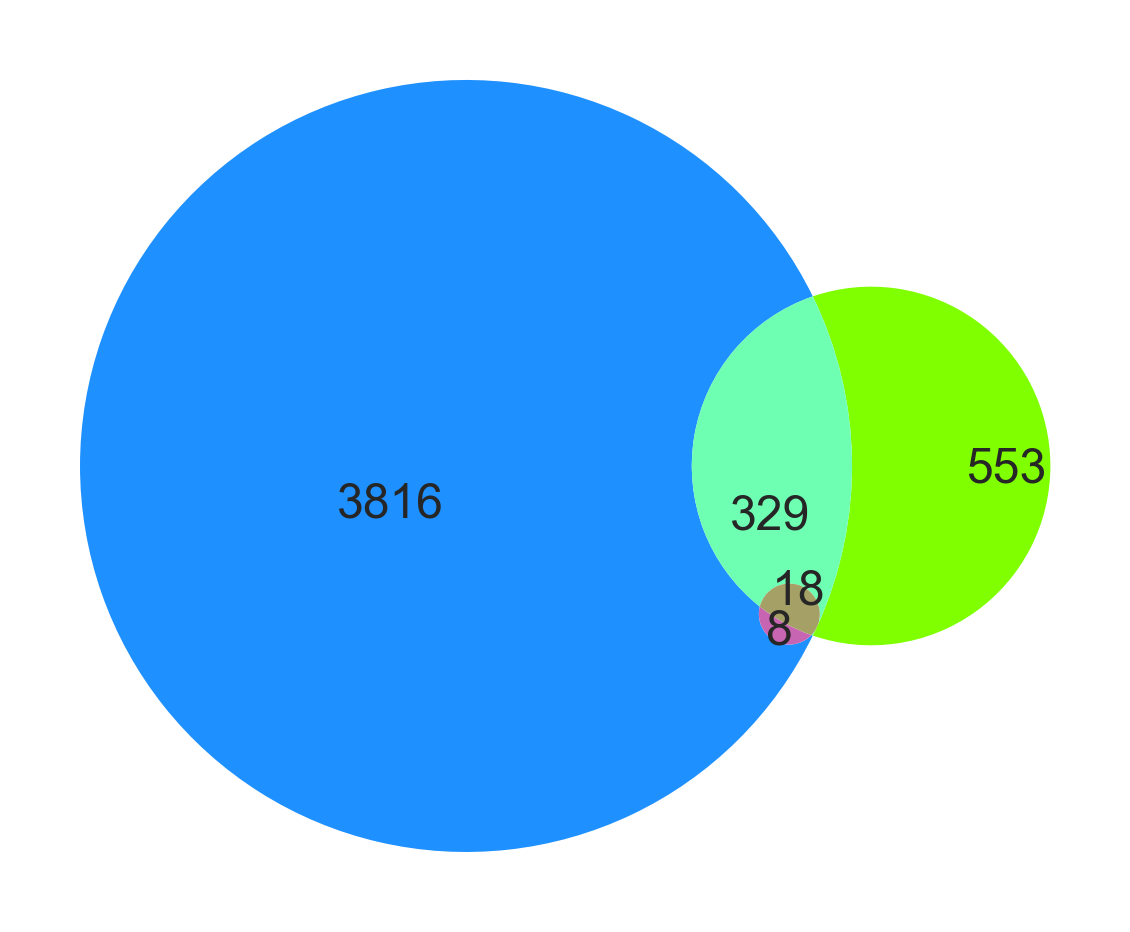

In [45]:
print(59)
plot_Venn3(topic_59_beta1, set_labels=None, figsize=(20, 20))
plot_Venn3(topic_59_beta4, set_labels=None, figsize=(20, 20))
print(47)
plot_Venn3(topic_47_beta2, set_labels=None, figsize=(20, 20))
plot_Venn3(topic_47_beta16, set_labels=None, figsize=(20, 20))
print(80)
plot_Venn3(topic_80_beta2, set_labels=None, figsize=(20, 20))
plot_Venn3(topic_80_beta8, set_labels=None, figsize=(20, 20))

In [20]:
year = 2015
topic = 59
beta_name = 'by_beta_4.0'

print('{0:.2f}'.format(metrics_d[year][topic]['betas'][beta_name]['scimacro_fscore']))
print('{0:.2f}'.format(metrics_d[year][topic]['betas'][beta_name]['boolean_fscore']))
print()

year = 2016
topic = 47
beta_name = 'by_beta_4.0'

print('{0:.2f}'.format(metrics_d[year][topic]['betas'][beta_name]['scimacro_fscore']))
print('{0:.2f}'.format(metrics_d[year][topic]['betas'][beta_name]['boolean_fscore']))
print()

year = 2015
topic = 80
beta_name = 'by_beta_4.0'

print('{0:.2f}'.format(metrics_d[year][topic]['betas'][beta_name]['scimacro_fscore']))
print('{0:.2f}'.format(metrics_d[year][topic]['betas'][beta_name]['boolean_fscore']))
print()

0.15
0.79

0.52
0.11

0.41
0.10



In [21]:
titles_59_beta1_b_retrieved = get_Titles(netid_2015_d, topic_59_beta1.b_retrieved)
titles_59_beta1_s_retrieved = get_Titles(netid_2015_d, topic_59_beta1.s_retrieved)
titles_59_beta4_s_retrieved = get_Titles(netid_2015_d, topic_59_beta4.s_retrieved)

In [10]:
# non retrieved relevant documents of 59

titles_pubmed_id_59 = [netid_2015_d[net_id] for net_id in topic_59_beta4.b_positives_not_in_s]
titles_dict_59 = {row[0]: row[1] for row in titles_59_beta1_b_retrieved}
titles_59 = [titles_dict_59[pubmed_id] for pubmed_id in titles_pubmed_id_59]
for title in titles_59:
    print(title)

13-cis-retinoic acid-associated bone marrow edema in neuroblastoma.
Early clinical indicators of transplant-associated thrombotic microangiopathy in pediatric neuroblastoma patients undergoing auto-SCT.
Long-term results for children with high-risk neuroblastoma treated on a randomized trial of myeloablative therapy followed by 13-cis-retinoic acid: a children's oncology group study.
Relationship among pharmacokinetics and pharmacodynamics of fenretinide and plasma retinol reduction in neuroblastoma patients.
Pharmacokinetics and metabolism of 13-cis-retinoic acid (isotretinoin) in children with high-risk neuroblastoma - a study of the United Kingdom Children's Cancer Study Group.
Favorable histology, MYCN-amplified 4S neonatal neuroblastoma.
Anti-GD2 antibody with GM-CSF, interleukin-2, and isotretinoin for neuroblastoma.
[Therapeutic experience of childhood stage III neuroblastoma].
A phase 2 trial of all-trans-retinoic acid in combination with interferon-alpha2a in children with rec

In [ ]:
# This list is so long that you always get some publications that dont conect with the API. I print the missing publications to get the latter

titles_47_beta2_b_retrieved = get_Titles(netid_2016_d, topic_47_beta2.b_retrieved)

In [256]:
# This are the publications I got from above

leftovers = [23585264,
21571263,
22374252,
19254808,
23880524,
17287698,
25630914,
22672499,
23261104,
19249893,
22287334,
25751810,
24637421,
25462210,
20175251,
24133106,
24530605,
23299775,
22464661,
16674017,
22767586,
25735449,
16528647,
16282732,
17561164,
19842232,
20496318,
22643497,
20336893,
18383983,
23828592,
17391619]

title_list = []

for pubid in leftovers:
    title = read_query.retrieve_Pubmed_Title(pubid)
    title_list.append(title)

In [259]:
# This adds the missing publications
titles_47_beta2_b_retrieved += title_list

In [260]:
titles_47_beta2_s_retrieved = get_Titles(netid_2016_d, topic_47_beta2.s_retrieved)

24460259
16174232
19797338


In [261]:
leftovers = [24460259,
16174232,
19797338]

title_list = []

for pubid in leftovers:
    title = read_query.retrieve_Pubmed_Title(pubid)
    title_list.append(title)

titles_47_beta2_s_retrieved += title_list

In [263]:
titles_47_beta16_s_retrieved = get_Titles(netid_2016_d, topic_47_beta16.s_retrieved)

21774880
22548742
21564463
16350554


In [265]:
leftovers = [21774880,
22548742,
21564463,
16350554]

title_list = []

for pubid in leftovers:
    title = read_query.retrieve_Pubmed_Title(pubid)
    title_list.append(title)

titles_47_beta16_s_retrieved += title_list

In [302]:
print('titles_80_beta2_b_retrieved')
titles_80_beta2_b_retrieved = get_Titles(netid_2015_d, topic_80_beta2.b_retrieved)
print('titles_80_beta2_s_retrieved')
titles_80_beta2_s_retrieved = get_Titles(netid_2015_d, topic_80_beta2.s_retrieved)
print('titles_80_beta8_s_retrieved')
titles_80_beta8_s_retrieved = get_Titles(netid_2015_d, topic_80_beta8.s_retrieved)

titles_80_beta1_b_retrieved
23838027
15505264
titles_80_beta1_s_retrieved
titles_80_beta4_s_retrieved


In [303]:
leftovers = [23838027,
15505264]

title_list = []

for pubid in leftovers:
    title = read_query.retrieve_Pubmed_Title(pubid)
    title_list.append(title)

titles_80_beta2_b_retrieved += title_list

In [11]:
np_59_beta1_b_retrieved = get_Nounphrases([x[1] for x in titles_59_beta1_b_retrieved])
np_59_beta1_s_retrieved = get_Nounphrases([x[1] for x in titles_59_beta1_s_retrieved])
np_59_beta4_s_retrieved = get_Nounphrases([x[1] for x in titles_59_beta4_s_retrieved])

np_47_beta2_b_retrieved = get_Nounphrases([x[1] for x in titles_47_beta2_b_retrieved])
np_47_beta2_s_retrieved = get_Nounphrases([x[1] for x in titles_47_beta2_s_retrieved])
np_47_beta16_s_retrieved = get_Nounphrases([x[1] for x in titles_47_beta16_s_retrieved])

np_80_beta2_b_retrieved = get_Nounphrases([x[1] for x in titles_80_beta2_b_retrieved])
np_80_beta2_s_retrieved = get_Nounphrases([x[1] for x in titles_80_beta2_s_retrieved])
np_80_beta8_s_retrieved = get_Nounphrases([x[1] for x in titles_80_beta8_s_retrieved])

In [35]:
pickle.dump(metrics_d, open('metrics_d.pickle', 'wb'))

pickle.dump(t_d, open('t_d.pickle', 'wb'))

In [49]:
# dump pickle

pickle.dump(ref_row_clean, open('ref_row_clean.pickle', 'wb'))
pickle.dump(year_pmid_netid_d_ref, open('year_pmid_netid_d_ref.pickle', 'wb'))
pickle.dump(year_netid_pmid_d_ref, open('year_netid_pmid_d_ref.pickle', 'wb'))

pickle.dump(netid_2015_d, open('netid_2015_d.pickle', 'wb'))
pickle.dump(netid_2016_d, open('netid_2016_d.pickle', 'wb'))

pickle.dump(metrics_d, open('metrics_d.pickle', 'wb'))

pickle.dump(t_d, open('t_d.pickle', 'wb'))

pickle.dump(titles_59_beta1_b_retrieved, open('titles_59_beta1_b_retrieved.pickle', 'wb'))
pickle.dump(titles_59_beta1_s_retrieved, open('titles_59_beta1_s_retrieved.pickle', 'wb'))
pickle.dump(titles_59_beta4_s_retrieved, open('titles_59_beta4_s_retrieved.pickle', 'wb'))

pickle.dump(titles_47_beta2_b_retrieved, open('titles_47_beta2_b_retrieved.pickle', 'wb'))
pickle.dump(titles_47_beta2_s_retrieved, open('titles_47_beta2_s_retrieved.pickle', 'wb'))
pickle.dump(titles_47_beta16_s_retrieved, open('titles_47_beta16_s_retrieved.pickle', 'wb'))

pickle.dump(titles_80_beta2_b_retrieved, open('titles_80_beta2_b_retrieved.pickle', 'wb'))
pickle.dump(titles_80_beta2_s_retrieved, open('titles_80_beta2_s_retrieved.pickle', 'wb'))
pickle.dump(titles_80_beta8_s_retrieved, open('titles_80_beta8_s_retrieved.pickle', 'wb'))

In [63]:
# Search titles of nounphrases

for title, np_list in zip(titles_47_beta2_b_retrieved, np_47_beta2_b_retrieved['titles']):
    if ('self',) in np_list:
        print(title[1])
        print()

Partially covered versus uncovered self-expandable nitinol stents with anti-migration properties for the palliation of malignant distal biliary obstruction: A randomized controlled trial.

Peroral placement of a self-expandable covered metallic stent using an overtube for malignant gastroduodenal obstructions.

Comparison of clinical outcomes between endoscopic and radiologic placement of self-expandable metal stent in patients with malignant colorectal obstruction.

The efficacy of self-expanding metal stents for malignant colorectal obstruction by noncolonic malignancy with peritoneal carcinomatosis.

Preoperative colonoscopy after self-expandable metallic stent placement in patients with acute neoplastic colon obstruction.

Outcome and safety of self-expandable metallic stents for malignant colon obstruction: a Korean multicenter randomized prospective study.

Self-expanding metal stents in malignant colonic obstruction: have we covered all angles?

Treatment of malignant gastric ou

In [453]:
topic = 59
year = 2015
for beta_name in metrics_d[year][topic]['betas']:
    scimacro_fscore = metrics_d[year][topic]['betas'][beta_name]['scimacro_fscore']
    max_net_fscore = metrics_d[year][topic]['betas'][beta_name]['max_net_fscore']
    print(beta_name)
    print(scimacro_fscore)
    print(max_net_fscore)


by_beta_0.125
0.7142857142857143
0.8387096774193549
by_beta_0.25
0.39534883720930225
0.5762711864406779
by_beta_0.5
0.16129032258064516
0.34883720930232553
by_beta_1.0
0.08823529411764705
0.19354838709677416
by_beta_2.0
0.10067114093959732
0.13392857142857142
by_beta_4.0
0.1476121562952243
0.1476121562952243
by_beta_8.0
0.19627579265223954
0.19627579265223954
by_beta_16.0
0.21503277088272207
0.21503277088272207
by_beta_32.0
0.2203748163543197
0.2203748163543197
by_beta_64.0
0.22175713344940504
0.22175713344940504
by_beta_128.0
0.22210574592150953
0.22210574592150953


In [451]:
for net_id in topic_59_beta1.b_positives_not_in_s:
    pubmed_id = netid_2015_d[net_id]
    for title in titles_59_beta1_b_retrieved:
        if title[0] == pubmed_id:
            print(title)
            break

(22354520, '13-cis-retinoic acid-associated bone marrow edema in neuroblastoma.')
(20697372, 'Early clinical indicators of transplant-associated thrombotic microangiopathy in pediatric neuroblastoma patients undergoing auto-SCT.')
(19171716, "Long-term results for children with high-risk neuroblastoma treated on a randomized trial of myeloablative therapy followed by 13-cis-retinoic acid: a children's oncology group study.")
(20532509, 'Relationship among pharmacokinetics and pharmacodynamics of fenretinide and plasma retinol reduction in neuroblastoma patients.')
(17224928, "Pharmacokinetics and metabolism of 13-cis-retinoic acid (isotretinoin) in children with high-risk neuroblastoma - a study of the United Kingdom Children's Cancer Study Group.")
(16333837, 'Favorable histology, MYCN-amplified 4S neonatal neuroblastoma.')
(20879881, 'Anti-GD2 antibody with GM-CSF, interleukin-2, and isotretinoin for neuroblastoma.')
(20973238, '[Therapeutic experience of childhood stage III neurobla

In [ ]:
def print_Data(np_count_l):
    np_list = [x[0] for x in np_count_l]
    number_list = [x[1] for x in np_count_l]
    for number_row in number_list:
        print(number_row)
    for np_row in np_list:
        np_string = functools.reduce(lambda x, y: x + ' ' + y, np_row)
        print(np_string)

In [51]:
print_Data(np_59_beta1_b_retrieved['count'][:20])

25
21
16
15
11
11
10
8
7
6
5
5
5
4
4
4
4
4
4
4
retinoic acid
neuroblastoma cell
differentiation
neuroblastoma
cis
apoptosis
child
risk neuroblastoma
tran retinoic acid
treatment
retinoid
stage
neuroblastoma cell line
human neuroblastoma cell
cell
combination
trial
fenretinide
induction
cis retinoic acid


In [52]:
print_Data(np_59_beta1_s_retrieved['count'][:20])

15
10
10
5
5
5
4
4
4
4
4
3
2
2
2
2
2
2
2
2
risk neuroblastoma
child
dose chemotherapy
patient
stage
tandem
autologous stem cell rescue
late effect
autologous stem cell transplantation
year
treatment
age
trial
autologous stem
megatherapy
result
report
outcome
feasibility
immunotherapy


In [53]:
print_Data(np_59_beta4_s_retrieved['count'][:20])

45
35
34
32
24
19
15
15
15
14
13
13
11
11
9
9
8
8
8
8
risk neuroblastoma
child
patient
neuroblastoma
mibg
stage
treatment
131i
metaiodobenzylguanidine
year
phase
dose chemotherapy
result
age
outcome
report
combination
comparison
risk
irinotecan


In [54]:
print_Data(np_47_beta2_b_retrieved['count'][:20])
# The most comon nounphrase is very low compared to the total number of titles
# This means that the tiles are divergent

395
207
203
121
114
112
110
109
101
100
88
77
74
68
63
63
62
59
58
52
patient
case report
case
self
management
colorectal cancer
surgery
review
treatment
report
literature
intussusception
outcome
bowel obstruction
year
analysis
comparison
adult
complication
chemotherapy


In [55]:
print_Data(np_47_beta2_s_retrieved['count'][:20])
# both "malignant bowel obstruction" and "bowel obstruction", notice this cluster uses "bowel", in opoosision of the uses of colorectal and colonic of the parent cluster
# octreotide
# mangment is only for bowel obstructions, not the other synonims

37
21
20
12
10
9
6
6
5
5
5
5
5
4
4
4
4
4
4
4
malignant bowel obstruction
patient
bowel obstruction
octreotide
management
treatment
palliative surgery
surgical management
outcome
advanced ovarian cancer
predictor
peritoneal carcinomatosis
cancer
efficacy
stage
ovarian cancer
palliative care
intestinal obstruction
palliation
inoperable bowel obstruction


In [56]:
print_Data(np_47_beta16_s_retrieved['count'][:20])
# self means self expandable
# bridge and surgery are for bridge as surgery
# patient is for patients with malignant bowel obstruction or one of the synonims
# tretement is because the papers talk about to how to treat something
# notice you have 3 synonims for malignant bowel obstruction, without countint colorectal cancer
# managment is for managing obstructions, either bowel, colorectal or colonic

99
91
69
54
47
47
45
42
41
41
38
35
32
31
30
28
26
25
24
24
self
patient
surgery
management
malignant bowel obstruction
bridge
malignant colorectal obstruction
colorectal cancer
treatment
malignant colonic obstruction
outcome
metallic stent
comparison
bowel obstruction
metal stent
stent
emergency surgery
analysis
palliation
expandable metal stent


In [19]:
print_Data(np_80_beta2_b_retrieved['count'][:20])

1387
1040
504
491
355
207
184
169
154
149
135
134
126
104
103
102
97
93
89
83
rheumatoid arthritis
patient
treatment
infliximab
rituximab
adalimumab
rheumatoid arthritis patient
disease
therapy
efficacy
safety
effect
tnf
response
result
case
use
syndrome
tocilizumab
psoriatic arthritis


In [60]:
print_Data(np_80_beta2_s_retrieved['count'][:20])

46
34
30
16
10
9
8
8
6
5
5
5
5
5
4
4
4
3
3
3
rheumatoid arthritis
rituximab
patient
safety
efficacy
treatment
result
methotrexate
use
active rheumatoid arthritis
combination
inadequate response
therapy
rheumatoid arthritis patient
systematic review
recommendation
analysis
study
phase
clinical outcome


In [18]:
print_Data(np_80_beta8_s_retrieved['count'][:20])

506
228
157
98
91
86
67
53
51
50
49
44
42
40
37
37
36
35
35
34
rheumatoid arthritis
patient
treatment
safety
tocilizumab
efficacy
rituximab
trial
analysis
active rheumatoid arthritis
methotrexate
golimumab
result
inadequate response
year
use
abatacept
rheumatoid arthritis patient
placebo
etanercept


In [390]:
for title, np_list in zip(titles_80_beta8_s_retrieved, np_80_beta8_s_retrieved['titles']):
    if ('certolizumab', 'pegol') in np_list:
        print(title[1])
        print()

Certolizumab pegol plus MTX administered every 4 weeks is effective in patients with RA who are partial responders to MTX.

Long-term efficacy and safety of certolizumab pegol in Japanese rheumatoid arthritis patients who could not receive methotrexate: 52-week results from an open-label extension of the HIKARI study.

Certolizumab pegol plus methotrexate is significantly more effective than placebo plus methotrexate in active rheumatoid arthritis: findings of a fifty-two-week, phase III, multicenter, randomized, double-blind, placebo-controlled, parallel-group study.

[Certolizumab pegol].

Predicting future response to certolizumab pegol in rheumatoid arthritis patients: features at 12 weeks associated with low disease activity at 1 year.

Targeting nanomedicines in the treatment of rheumatoid arthritis: focus on certolizumab pegol.

Certolizumab pegol.

Efficacy and safety of certolizumab pegol in rheumatoid arthritis: meeting rheumatologists' requirements in routine clinical practi

In [391]:
for title, np_list in zip(titles_80_beta2_b_retrieved, np_80_beta2_b_retrieved['titles']):
    if ('certolizumab', 'pegol') in np_list:
        print(title[1])
        print()

Efficacy and safety of certolizumab pegol plus methotrexate in active rheumatoid arthritis: the RAPID 2 study. A randomised controlled trial.

Certolizumab pegol plus MTX administered every 4 weeks is effective in patients with RA who are partial responders to MTX.

RAPID3 (Routine Assessment of Patient Index Data 3) severity categories and response criteria: Similar results to DAS28 (Disease Activity Score) and CDAI (Clinical Disease Activity Index) in the RAPID 1 (Rheumatoid Arthritis Prevention of Structural Damage) clinical trial of certolizumab pegol.

Meta-analysis: the efficacy and safety of certolizumab pegol in Crohn's disease.

Certolizumab pegol: in rheumatoid arthritis.



In [353]:
# self is for self expandable metal stent
# brige is for bridge surgery

target = ('case',)
target_title_l = []
for words, title in zip(np_words_l_l, title_list):
    if target in words:
        target_title_l.append(title)

In [63]:
np_59_beta1_b_retrieved.keys()

dict_keys(['titles', 'count'])

In [18]:
titles_pubmed_id_80 = [netid_2015_d[net_id] for net_id in topic_80_beta8.s_retrieved]
titles_pubmed_id_80

[20957659,
 20403067,
 23777823,
 20080910,
 20194448,
 23447479,
 20864908,
 24670196,
 24593201,
 16798046,
 21097801,
 16984942,
 16393444,
 16265687,
 21821865,
 20091667,
 24368513,
 21822056,
 23334372,
 23728498,
 15686185,
 22562389,
 22975733,
 23228348,
 16569995,
 16540554,
 19340851,
 19382999,
 21079302,
 21735355,
 22344576,
 24372225,
 23728649,
 22302417,
 15335295,
 18388156,
 15152062,
 17413494,
 19751268,
 22175141,
 18512708,
 17552048,
 20179326,
 23043846,
 23464803,
 24754273,
 18601859,
 18028004,
 23624939,
 20433955,
 20334454,
 22093579,
 20346251,
 19368420,
 23136242,
 23547848,
 25168268,
 24001888,
 18975346,
 15794709,
 24099961,
 20965769,
 15756499,
 23642688,
 24037395,
 19449016,
 18383390,
 21182357,
 19721444,
 15146410,
 20950126,
 16925504,
 21848493,
 21794764,
 25054605,
 22640174,
 23800448,
 22392766,
 17062648,
 15799401,
 21708910,
 24870729,
 22735599,
 22151924,
 18163481,
 21989284,
 21328309,
 16785475,
 22948700,
 22231904,
 19936725,

In [11]:
titles_pubmed_id_59 = [netid_2015_d[net_id] for net_id in topic_59_beta4.b_positives_not_in_s]
titles_dict_59 = {row[0]: row[1] for row in titles_59_beta1_b_retrieved}
titles_59 = [titles_dict_59[pubmed_id] for pubmed_id in titles_pubmed_id_59]
for title in titles_59:
    print(title)

13-cis-retinoic acid-associated bone marrow edema in neuroblastoma.
Early clinical indicators of transplant-associated thrombotic microangiopathy in pediatric neuroblastoma patients undergoing auto-SCT.
Long-term results for children with high-risk neuroblastoma treated on a randomized trial of myeloablative therapy followed by 13-cis-retinoic acid: a children's oncology group study.
Relationship among pharmacokinetics and pharmacodynamics of fenretinide and plasma retinol reduction in neuroblastoma patients.
Pharmacokinetics and metabolism of 13-cis-retinoic acid (isotretinoin) in children with high-risk neuroblastoma - a study of the United Kingdom Children's Cancer Study Group.
Favorable histology, MYCN-amplified 4S neonatal neuroblastoma.
Anti-GD2 antibody with GM-CSF, interleukin-2, and isotretinoin for neuroblastoma.
[Therapeutic experience of childhood stage III neuroblastoma].
A phase 2 trial of all-trans-retinoic acid in combination with interferon-alpha2a in children with rec